In [ ]:
import tensorflow as tf
import numpy as np
import torch
import math
import os
import json
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [ ]:
import torch

def psnr_part(M_true, M_Est, Omega):
    M_true = M_true/torch.max(M_true)
    maxP=1
    M_Est = torch.clamp(M_Est, 0.0, maxP)
    dim = M_Est.size()
    MSE = torch.norm(M_true*Omega - M_Est*Omega)**2 / Omega.sum()
    psnr_re = 10 * torch.log10(maxP**2 / MSE)
    return psnr_re

def psnr(M_true, M_Est):
    M_true = M_true/torch.max(M_true)
    maxP=1
    M_Est = torch.clamp(M_Est, 0.0, maxP)
    dim = M_Est.size()
    MSE = torch.norm(M_true - M_Est)**2 / torch.prod(torch.tensor(dim, dtype=torch.float32))
    psnr_re = 10 * torch.log10(maxP**2 / MSE)
    return psnr_re

def mse(M_true, M_Est):
    dim = M_Est.size()
    mse_re = torch.norm(M_true - M_Est)**2 / torch.prod(torch.tensor(dim, dtype=torch.float32))
    return mse_re



## Loading BSD500 and dividing datasets

In [ ]:
from scipy.io import loadmat
mat_data = loadmat('img_data.mat')
M=torch.tensor(np.float32(mat_data['data']))
if torch.cuda.is_available():
    M = M.to('cuda')
#print(M)

In [ ]:
print(M.shape)

torch.Size([321, 481, 150])


# BO backage

In [ ]:
try:
    import torch
except ImportError:
    %pip install torch
    import torch

try:
    import botorch
    import gpytorch
except ImportError:
    %pip install botorch
    import botorch
    import gpytorch

try:
    import tqdm.notebook as tqdm
except ImportError:
    %pip install tqdm
    import tqdm.notebook as tqdm

# Ensure that we are using double precision, for numerical stability
torch.set_default_dtype(torch.float64)

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Supress BoTorch's InputWarnings
import warnings
warnings.filterwarnings("ignore", message="Input data is not standardized")

In [ ]:
sigma = 0.1  # Observational noise standard deviation, which can be tuned

In [ ]:
def create_gp_conditioned_on_data(train_X, train_Y):
    """ Constructs a GP surrogate model that's conditioned on the dataset (train_X, train_Y) """
    # train_X: a [N x 1] matrix of inputs in our training set (on the domain [0, 1])
    # train_y: a [N x 1] matrix of (noisy) observations that correspond to the train_X inputs

    # This GP will use
    # - A zero mean
    # - A Matern kernel
    gp = botorch.models.SingleTaskGP(
        train_X, train_y,  # initial data
        mean_module=gpytorch.means.ZeroMean(),  # Prior mean
        covar_module=gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=1))  # Prior covariance
    )

    # Typically, we would learn the hyperparameters of our mean and covariance function
    # To keep things simple for this 1D toy demonstration, we'll lock them down
    gp.likelihood.initialize(noise=(sigma ** 2))  # Observational noise in our likelihood
    gp.covar_module.initialize(outputscale=1.)  # Covariance function outputscale
    gp.covar_module.base_kernel.initialize(lengthscale=[0.2])  # Covariance function lengthscale

    return gp

def policy(gp):
    """Optimizes the acquisition function, and returns a new candidate."""
    # gp: the posterior GP model

    ## TODO: change this acquisition function with the appropriate acquisition function of your choosing
    ## Examples:
    ##    - botorch.acquisition.analytic.UpperConfidenceBound
    ##    - botorch.acquisition.analytic.ExpectedImprovement
    ##    - botorch.acquisition.knowledge_gradient.qKnowledgeGradient
    ## See https://botorch.org/api/acquisition.html for documentation
    acq_func = botorch.acquisition.knowledge_gradient.qKnowledgeGradient(
        model=gp,
        #best_f=train_y.max()
    )

    # Find new X value that optimizes the acquisition function
    # BoTorch's optimize_acqf does a few fancy tricks under the hood to search the input space for
    #  for the best candidate. Increasing raw_samples and num_restarts should improve the quality of
    #  the search
    new_X, _ = botorch.optim.optimize_acqf(
        acq_function=acq_func,
        bounds=input_bounds,
        q=1,  # This means that we are only choosing 1 new X value per iteration
        raw_samples=512,  # How many candidates we should consider - sampled randomly from the input space
        num_restarts=2,  # How many sets of candidates we should consider (more is better)
    )

    return new_X, acq_func

def update_dataset(train_X, train_y, new_X, new_y):
    """Adds a new input/observation pair to the existing dataset of inputs/observations"""
    # train_X: [N x 1] matrix of existing inputs
    # train_y: [N x 1] matrix of existing noisy objective function observations at input locations
    # new_X: [1 x 1] matrix with the new input
    # new_y: [1 x 1] matrix with the new observed value

    train_X = torch.cat([train_X, new_X], dim=-2)
    #print(train_X)
    train_y = torch.cat([train_y, new_y], dim=-2)
    return train_X, train_y

def plot_gp_posterior_and_acq_func(gp, acq_func, train_X, train_y, gp_ax, acq_ax, idx=None):
    # gp: the posterior GP model
    # acq_func: a module that computes the acquisition function
    # train_X: [N x 1] matrix of inputs
    # train_y: [N x 1] matrix of noisy objective function observations at input locations
    # gp_ax and acq_ax: figure axes to plot results on
    # idx: iteration index (for title)

    # Define points to evaluate our surrogate model and acq function at
    test_X = torch.linspace(input_bounds[0, 0].item(), input_bounds[1, 0].item(), 101).unsqueeze(-1)
        # A [101 x 1] matrix, spanning the compact domain that we are considering

    # Compute GP posterior @ test_X
    with torch.no_grad():
        gp.eval()
        test_f_posterior = gp.posterior(test_X)
        mean = test_f_posterior.mean.squeeze(-1)
        stdv = test_f_posterior.stddev.squeeze(-1)

    # Compute acquisition function @ test_X
    with torch.no_grad():
        test_X_expanded = test_X[..., None, :]
        if isinstance(acq_func, botorch.acquisition.knowledge_gradient.qKnowledgeGradient):
            test_X_expanded = test_X_expanded + torch.zeros(acq_func.num_fantasies + 1, 1)
        acq_test_X = acq_func(test_X_expanded)

    # Plot everything
    gp_ax.plot(test_X.numpy(), toy_1d_objective(test_X).numpy(), "k--", zorder=-2, label="True Objective")
    mean_line, = gp_ax.plot(test_X.numpy(), mean.numpy(), color="blue", zorder=0, label="Posterior Mean")
    gp_ax.fill_between(
        test_X[..., 0].numpy(), (mean - 2 * stdv).numpy(), (mean + 2 * stdv).numpy(),
        color=mean_line.get_color(), zorder=-1, alpha=0.33
    )
    gp_ax.scatter(
        train_X[..., 0].numpy(), train_y.numpy(),
        marker="o", edgecolors="k", color="white", label="Train Data"
    )
    gp_ax.set(xlabel="x", ylabel="f(x)", title=f"Iteration {idx}" if idx is not None else None)
    if idx == 0:
        gp_ax.legend(loc="best")

    # Plot everything
    idx_max = acq_test_X.argmax(dim=-1)
    acq_ax.plot(test_X.numpy(), acq_test_X.numpy(), color="green", zorder=0, label="Acq. Func")
    acq_ax.scatter(
        test_X[idx_max].numpy(), acq_test_X[idx_max].numpy(),
        marker="s", edgecolors="k", color="white", label="Maximizer"
    )
    acq_ax.set(xlabel="x", ylabel="a(x | f, D)", title=f"Iteration {idx}" if idx is not None else None)
    if idx == 0:
        acq_ax.legend(loc="best")

# tWLRTC

## Codes for PADMM-based low rank tensor completion

In [ ]:
import torch

def GetOmega(Osize, p):
    Omega = torch.rand(Osize)
    mask = Omega < p
    Omega[mask] = 1.0
    Omega[~mask] = 0.0
    return Omega

def GenDic(Data,n):
  fD =  torch.fft.fft(Data,  dim=2)
  newfD=torch.zeros(Data.shape[0],n,Data.shape[2],dtype=torch.float32)
  n3=Data.shape[2]
  for i in range(n3):
    column_indices = torch.randperm(Data.shape[1])[:n]
    column_norms = torch.norm(fD[:,column_indices,i], p=2, dim=0)
    newfD[:,:,i] = fD[:,column_indices,i] / column_norms
  D =  torch.fft.ifft(newfD,  dim=2)
  return torch.real(D)



def GenArr(Asize,tensor):
  array_of_tensors = []
  rows=Asize[0]
  cols=Asize[1]
  for i in range(rows):
    row = []
    for j in range(cols):
      #tensor = torch.zeros((i + 1, j + 1))
      row.append(tensor)
    array_of_tensors.append(row)
  return array_of_tensors

def GenArr_random(Asize,tsize):
  array_of_tensors = []
  rows=Asize[0]
  cols=Asize[1]
  for i in range(rows):
    row = []
    for j in range(cols):
      tensor = torch.randn(tsize)
      row.append(tensor)
    array_of_tensors.append(row)
  return array_of_tensors

def GenArr_U(h,tsize):
  U = []
  for i in range(h):
    tensor = torch.eye(tsize[i],dtype=torch.float64)
    U.append(tensor)
  return U

def GenArr_Uarr(h,tsize):
  Uarr = [[0,GenArr_U(h,tsize),GenArr_U(h,tsize),GenArr_U(h,tsize)],[0,0,GenArr_U(h,tsize),GenArr_U(h,tsize)],[0,0,0,GenArr_U(h,tsize)],[0,0,0,0]]
  return Uarr

In [ ]:
import torch.nn as nn

class tWLRTC_4D_PADMM(nn.Module):
  def __init__(self, weight, stagesNum=300, rho=1.1,mu=10**(-4),muij=torch.tensor([[0,1,1,1],[0,0,1,1],[0,0,0,1],[0,0,0,0]],dtype=torch.float64),xi=10**(-4),setH=[]):
    super(tWLRTC_4D_PADMM, self).__init__()
    self.eps=0.00001
    self.max_mu=10000
    self.max_xi=10000
    self.stagesNum=stagesNum # the number of iteration of the algorithm
    self.rho=rho
    self.mu=mu
    self.xi=xi
    self.weight=weight # the weighted parameters in the proposed norm
    self.setH=setH # the set of indeice of the dimention of tensor data with non-smooth changing ( and the U  we want to learn from data)
    self.muij=muij


  def forward(self, M, Omega):
    # input: M: observed tensor
    #        Omega: position tensor conposed of 0,1, the elements with value 1 correspond to the sampled elemens

   #The following codes are using PADMM for solving the proposed model (i.e., Eq (3) in the attached tiny paper)
   # Please refer the Algorithm 2.
   self.M=M.clone()
   self.Omega=Omega.clone()

   # Initialization of the varibles
   Msize = self.M.shape
   h=self.M.ndimension()
   oldE=torch.zeros(Msize)
   oldYij=GenArr((h,h),torch.zeros(Msize))
   oldYY=torch.zeros(Msize)
   oldUarr=GenArr_Uarr(h,Msize)
   Uarr=oldUarr
   oldX=self.M
   oldZ=GenArr((h,h),torch.zeros(Msize,dtype=torch.float64))


   for i in range(self.stagesNum):
      Z=self.update_Z(oldX,oldYij,oldUarr,oldZ)
      X=self.update_X(oldE, Z, oldUarr, oldYij,oldYY,oldX)
      E=self.update_E(X,oldYY, oldE)
      for ii in range(h):
        for jj in range(h):
          if ii<jj:
            Uarr[ii][jj]=self.update_U(Z[ii][jj],X,oldUarr[ii][jj],oldYij[ii][jj],self.mu*self.muij[ii,jj],self.setH)

      Yij=self.update_Yij(X, Z, oldYij,Uarr)
      YY=self.update_YY(X, E, oldYY)
      self.update_mu_xi()
      oldZ=Z
      oldE=E
      oldYij=Yij
      oldYY=YY
      oldUarr=Uarr
      oldX=X
      if i%10==999:
        print("Itertive Number: {}".format(i),  "Error: {}".format(torch.norm(self.M-X-E)))
   return X, E, 0



  def update_E(self, X, YY,oldE):
    E=(self.mu*(self.M-X+YY/self.mu)+self.xi*oldE)*(1-self.Omega)/(self.mu+self.xi)
    return E



  def update_X(self, E, Z, Uarr, Y, YY,oldX):
    Msize = self.M.size()
    h=self.M.ndimension()
    sumP=self.mu*(self.M-E)+YY+self.xi*oldX
    den=self.mu+self.xi

    for i in range(h):
      for j in range(h):
        if i<j :
          sumP+=self.muij[i,j]*self.mu*self.ApplyUT(Z[i][j],Uarr[i][j],self.setH)+Y[i][j]
          den+=self.muij[i,j]*self.mu
    return sumP/den

  def ApplyU(self, H, UU,setHH):
    Msize=self.M.size()
    h=self.M.ndimension()
    Tensor=H.clone()
    for k in setHH:
      Tensor=self.tmprod(Tensor,UU[k],k)
    return Tensor

  def ApplyUT(self, H, UU,setHH):
    Msize=self.M.size()
    h=self.M.ndimension()
    Tensor=H.clone()
    for k in setHH:
      Tensor=self.tmprod(Tensor,UU[k].t(),k)
    return Tensor

  def update_U(self,Zij,X,oldU,Yij,muij0,setHH):
    U=oldU.copy()
    Msize=self.M.size()
    A0=Zij
    summu=0.0

    B0=muij0*X-Yij
    for t in setHH:
      A=A0.clone()
      B=B0.clone()
      # update U_t
      for k in setHH:
        if k > t:
          A=self.tmprod(A,U[k].t(),k)
        elif k < t:
          B=self.tmprod(B,U[k],k)
      Ak,nAsize=self.mFolding(A,t)
      Bk,nBsize=self.mFolding(B,t)
      U0, S0, V0T=torch.linalg.svd(torch.matmul(Ak,Bk.t())+self.xi*oldU[t])
      U[t]=U0 @ V0T
    return U

  def tmprod(self,A,Q,k):
    Msize=self.M.size()
    h=self.M.ndimension()
    Tensor=A.clone()
    reshaped_tensor,Tsize = self.mFolding(Tensor,k)
    newTensor=self.mUnfolding(torch.matmul(Q,reshaped_tensor),k,Tsize)
    return newTensor

  def mFolding(self,A,k):
    Asize=A.size()
    h=A.ndimension()
    dims=tuple([x + k for x in range(h-k)])+tuple(range(k))
    Tensor=A.permute(dims)
    reshaped_tensor = Tensor.reshape(Asize[k], -1)
    return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()

  def mUnfolding(self,matrixA,k,nAsize):
    Msize=self.M.size()
    h=self.M.ndimension()
    invdims=tuple([x + h-k for x in range(k)])+tuple(range(h-k))
    TensorA=matrixA.reshape(nAsize)
    return TensorA.permute(invdims)


  def update_Z(self,X,Yij,oldUarr, oldZ):
    Msize = self.M.size()
    h=self.M.ndimension()
    Z=GenArr((h,h),torch.zeros(Msize))
    for i in range(h):
      for j in range(h):
        if i<j :
          TemT=(self.ApplyU(self.muij[i,j]*self.mu*X-Yij[i][j],oldUarr[i][j],self.setH)+self.xi*oldZ[i][j])/(self.muij[i,j]*self.mu+self.xi)
          Rdim=[]
          for s in range(h):
            if s not in np.array([i,j]):
              Rdim.append(s)
          Zij=self.tSVT(TemT.permute(i,j,Rdim[0],Rdim[1]), self.weight[i,j]/(self.muij[i,j]*self.mu+self.xi))
          ivaxi=torch.argsort(torch.tensor([i,j,Rdim[0], Rdim[1]]))
          Z[i][j]=Zij.permute(ivaxi[0],ivaxi[1],ivaxi[2],ivaxi[3])#self.ApplyUT(Zij.permute(ivaxi[0],ivaxi[1],ivaxi[2],ivaxi[3]),oldU)
    return Z

  def update_Yij(self,X, Z, oldY,Uarr):
    h=self.M.ndimension()
    newY = oldY.copy()
    for i in range(h):
      for j in range(h):
        if i<j :
          ZUT=self.ApplyUT(Z[i][j],Uarr[i][j],self.setH)
          newY[i][j]= oldY[i][j] + self.muij[i,j]*self.mu * (ZUT-X)
    return newY
  def update_YY(self,X, E, oldYY):
    YY = oldYY + self.mu * (self.M-X-E)
    return YY

  def update_mu_xi(self):
    self.mu = min(self.rho * self.mu, self.max_mu)
    self.xi = min(self.rho * self.xi, self.max_xi)

  def tSVT(self,C, rho):
      n1, n2, n3, n4 = C.size()
      fC =  torch.fft.fft(C,  dim=2)
      fC =  torch.fft.fft(fC,  dim=3)
      fL= torch.zeros(n1,n2,n3,n4,dtype=torch.complex64)
      for i in range(n3):
        for j in range(n4):
         U, S, V = torch.linalg.svd(fC[:,:, i, j])
         r= torch.sum(S > rho).item()
         if r >= 1:
          S0 = S[:r] - rho
          S0 = S0.to(U.dtype)
          fL[:,:,i, j] = U[:,:r] @ S0.diag() @ V[:r,:]
      fL=torch.fft.ifft(fL,  dim=2)
      L=torch.fft.ifft(fL,  dim=3)
      return torch.real(L)

In [ ]:
# def mFolding(A,k):
#     Asize=A.size()
#     h=A.ndimension()
#     dims=tuple([x + k for x in range(h-k)])+tuple(range(k))
#     Tensor=A.permute(dims)
#     reshaped_tensor = Tensor.reshape(Asize[k], -1)
#     return reshaped_tensor, Tensor.size()

# def mUnfolding(matrixA,k,nAsize):
#     h=3
#     invdims=tuple([x + h-k for x in range(k)])+tuple(range(h-k))
#     TensorA=matrixA.reshape(nAsize)
#     return TensorA.permute(invdims)

# def tmprod(A,Q,k):
#     h=A.ndimension()
#     Tensor=A.clone()
#     reshaped_tensor,Tsize = mFolding(Tensor,k)
#     newTensor=mUnfolding(torch.matmul(Q,reshaped_tensor),k,Tsize)
#     return newTensor


# def tSVT(C, rho):
#       n1, n2, n3= C.size()
#       fC =  torch.fft.fft(C,  dim=2)
#       Q=torch.tensor([[-0.1231,0.9045,0.4082],[-0.4924,0.3015,-0.8165],[-0.8616, -0.3015,0.4082]],dtype=torch.float64)
#       fL= torch.zeros(n1,n2,n3,dtype=torch.complex64)
#       for i in range(n3):
#          U, S, V = torch.linalg.svd(Q@fC[:,:, i])
#          r= torch.sum(S > rho).item()
#          if r >= 1:
#           S0 = S[:r] - rho
#           S0 = S0.to(U.dtype)
#           fL[:,:,i] = U[:,:r] @ S0.diag() @ V[:r,:]
#       L=torch.fft.ifft(fL,  dim=2)
#       return torch.real(L)

## PADMM


Illustration for our test data:
In our experiments, we construct our tensor data with size of $ 321 \times  481  \times 3 \times 50$ by stacking 50 color images randomly choosen from BSD.

Therefore, it is a fourth-order tensor completion problem, and the proposed norm have $4*3/2=6$ weighted parameters in total.


Illustration for c and r:
c is the sampling rate. We divide the observed element parts into two parts:
one is used for the lower problem,  
another one is used for the upper problem, where $r*c$ is the sampling rate for the lower problem and the remaining $(1-r)*c$ elements is used for evaluating w.

### The following are codes and results for c=0.3 and r=0.5

Since high computation complex of tensor completion, I sample the slices from the original whole tensor data randomly to get a smaller tensor data that will be used in the bilevel problem.

In [ ]:
import torch
import torch.nn.functional as F

def SamEn4D(Omega0,r0):
  SamPos=torch.zeros(Omega0.shape)
  ind_ones = torch.nonzero(Omega0 == 1, as_tuple=False)
  for i in range(ind_ones.shape[0]):
    if torch.rand(1)[0] < r0:
      indPos=ind_ones[i]
      SamPos[indPos[0],indPos[1],indPos[2],indPos[3]]=1.0
  return SamPos

n1,n2=M.shape[0],M.shape[1]
M0=torch.zeros(n1,n2,3,50,dtype=torch.float32)
for i in range(50):
  M0[:,:,:,i]=M[:,:,i*3:(i+1)*3]

Data=M0 / torch.max(M0)
MxP=torch.max(M)
p=0.3;
Omega = GetOmega(Data.size(),p);
Data=Data*Omega;
r=0.5
resized_Data = Data[::15,:,:,:]
resized_Data = resized_Data[:,::15,:,:]
resized_Data = resized_Data[:,:,:,:]
resized_Data = resized_Data[:,:,:,::15]
resized_Omega = Omega[::15,:,:,:]
resized_Omega = resized_Omega[:,::15,:,:]
resized_Omega = resized_Omega[:,:,:,:]
resized_Omega = resized_Omega[:,:,:,::15]
sampPos=SamEn4D(resized_Omega,r)
print(resized_Omega.shape)
h=4
sigma = 0.1

torch.Size([22, 33, 3, 4])


BO for our method

In [ ]:
def unPSNR_objective(w, Data0, Omega0, SamPos):
    weight=torch.tensor([[0,w[0],w[1],w[2]],[0,0,w[3],w[4]],[0,0,0,w[5]],[0,0,0,0]])
    fwd=tWLRTC_4D_PADMM(weight, stagesNum=100,rho=1.1,mu=10**(-4), xi=10**(-20), setH=np.array([3]))
    reX,_,_=fwd(Data0*(1-SamPos), Omega0*(1-SamPos))
    onorm=psnr_part(Data0,reX,SamPos)
    return torch.tensor([[onorm]])

def observe(w, resized_Data, resized_Omega, SamPos):
  #ObservedMSE_objective(w, resized_Data, resized_Omega)
  return unPSNR_objective(w[0], resized_Data, resized_Omega, SamPos) #oriObj_objective(w[0], resized_Data, resized_Omega)

input_bounds=torch.tensor([[0.0,0.0,0.0,0.0,0.0,0.0],[1.0,1.0,1.0,1.0,1.0,1.0]])
## initial weight
initial_w=torch.tensor([[1/6,1/6,1/6,1/6,1/6,1/6]])
initial_y = observe(initial_w, resized_Data, resized_Omega,sampPos)
print(initial_w, initial_y)
# Our initial dataset
train_X = initial_w
train_y = initial_y

w_list= torch.tensor([[1.0,0,0,0,0,0],[0,1.0,0,0,0,0],[0,0,1.0,0,0,0],[0,0,0,1.0,0,0],[0,0,0,0,1.0,0],[0,0,0,0,0,1.0]]) #torch.tensor([1,0])
for i in range(w_list.shape[0]):
    X_i = w_list[i:i+1,:]
    y_i = observe(X_i, resized_Data, resized_Omega,sampPos)
    print(X_i, y_i)
    train_X, train_y = update_dataset(train_X, train_y, X_i, y_i)

T = 50  # Number of iterations
#fig, axs = plt.subplots(T + 1, 2, figsize=(8, 2 * (T + 1)), sharex=True, sharey="col")
    # Figure to plot posterior and acquisition function



# Optimization loop
for i in tqdm.tqdm(range(T), desc="Optimization Iteration"):
    # Here's the typical optimization loop that we've seen in class a bunch of times

    # Step 0: compute the posterior of our GP surrogate model of the objective function
    gp = create_gp_conditioned_on_data(train_X, train_y)

    # Step 1: choose a new point to observe the objective function at
    X_i, acq_func = policy(gp)

    # An additional step: let's plot the GP and policy to observe what's going on
   # (gp_ax, acq_ax) = axs[i]
   # plot_gp_posterior_and_acq_func(gp, acq_func, train_X, train_y, gp_ax, acq_ax, idx=i)

    # Step 2: make an observation at the selected input
   # print(X_i)
    y_i = observe(X_i, resized_Data, resized_Omega,sampPos)

    print(i, X_i, y_i)
    # Step 3: update the dataset with our new input/observaiton pair
    train_X, train_y = update_dataset(train_X, train_y, X_i, y_i)

# Plot final GP posterior with all acquired data
gp = create_gp_conditioned_on_data(train_X, train_y)
#plot_gp_posterior_and_acq_func(gp, acq_func, train_X, train_y, axs[-1, 0], axs[-1, 1], idx=T)
#fig.tight_layout()

print('Best result:', train_y.max())

/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


tensor([[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]]) tensor([[16.5445]])
tensor([[1., 0., 0., 0., 0., 0.]]) tensor([[15.2768]])
tensor([[0., 1., 0., 0., 0., 0.]]) tensor([[15.5581]])
tensor([[0., 0., 1., 0., 0., 0.]]) tensor([[15.9463]])
tensor([[0., 0., 0., 1., 0., 0.]]) tensor([[15.8331]])
tensor([[0., 0., 0., 0., 1., 0.]]) tensor([[15.9434]])
tensor([[0., 0., 0., 0., 0., 1.]]) tensor([[15.8459]])


Optimization Iteration:   0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


0 tensor([[0.2159, 0.1819, 0.1762, 0.1938, 0.1697, 0.1762]]) tensor([[16.5075]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


1 tensor([[0.1962, 0.9332, 0.2410, 0.4651, 0.4989, 0.6894]]) tensor([[16.6329]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


2 tensor([[0.9870, 0.1041, 0.3453, 0.6651, 0.0520, 0.7036]]) tensor([[16.2556]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


3 tensor([[0.6600, 0.4326, 1.0000, 0.4658, 0.3430, 0.4049]]) tensor([[16.4826]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


4 tensor([[0.8548, 0.3389, 0.4447, 0.9848, 0.0011, 0.6608]]) tensor([[16.3804]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


5 tensor([[0.4053, 0.8212, 0.2467, 0.8566, 0.8776, 0.7691]]) tensor([[16.6172]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


6 tensor([[0.2793, 0.8357, 0.7581, 0.2992, 0.1868, 0.4394]]) tensor([[16.6055]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


7 tensor([[0.8755, 0.3017, 0.4294, 0.9328, 0.0098, 0.6673]]) tensor([[16.3665]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


8 tensor([[0.6460, 0.4469, 0.9872, 0.4609, 0.3357, 0.4073]]) tensor([[16.4818]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


9 tensor([[0.2597, 0.5359, 0.6354, 0.5459, 0.3387, 0.2793]]) tensor([[16.6202]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


10 tensor([[0.2017, 0.9356, 0.2157, 0.5008, 0.5402, 0.7126]]) tensor([[16.6357]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


11 tensor([[0.3594, 0.0686, 0.3797, 0.5164, 0.6155, 0.6661]]) tensor([[16.6192]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


12 tensor([[0.2437, 0.5092, 0.6161, 0.5773, 0.3535, 0.2535]]) tensor([[16.6173]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


13 tensor([[0.7720, 0.9672, 0.4725, 0.5007, 0.2144, 0.4993]]) tensor([[16.4199]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


14 tensor([[0.8729, 0.2409, 0.0637, 0.1051, 0.6066, 0.2683]]) tensor([[16.1672]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


15 tensor([[0.9212, 0.4849, 0.0119, 0.4569, 0.2818, 0.9924]]) tensor([[16.3628]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


16 tensor([[0.2872, 0.2233, 0.9263, 0.9167, 0.5389, 0.9988]]) tensor([[16.7271]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


17 tensor([[0.8716, 0.5062, 0.0431, 0.3967, 0.4616, 0.6553]]) tensor([[16.3088]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


18 tensor([[0.2894, 0.4908, 0.6325, 0.5636, 0.3572, 0.2833]]) tensor([[16.6177]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


19 tensor([[0.6859, 0.4204, 0.8497, 0.8444, 0.9162, 0.9184]]) tensor([[16.6140]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


20 tensor([[0.2633, 0.5125, 0.5833, 0.5498, 0.3538, 0.2953]]) tensor([[16.6192]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


21 tensor([[0.2786, 0.5423, 0.6150, 0.5912, 0.3675, 0.2914]]) tensor([[16.6143]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


22 tensor([[0.2470, 0.5070, 0.6255, 0.5827, 0.3394, 0.3135]]) tensor([[16.6383]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


23 tensor([[0.9378, 0.4426, 0.0709, 0.1506, 0.4098, 0.5061]]) tensor([[16.1944]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


24 tensor([[0.6647, 0.3167, 0.9711, 0.2711, 0.8234, 0.9489]]) tensor([[16.6007]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


25 tensor([[0.7817, 0.8597, 0.7880, 0.5780, 0.2576, 0.6535]]) tensor([[16.4771]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


26 tensor([[0.2446, 0.5148, 0.6310, 0.5542, 0.3929, 0.2975]]) tensor([[16.6374]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


27 tensor([[0.2985, 0.8113, 0.7437, 0.3274, 0.2048, 0.4359]]) tensor([[16.6127]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


28 tensor([[0.3026, 0.5346, 0.6108, 0.5691, 0.3133, 0.2987]]) tensor([[16.5981]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


29 tensor([[0.2723, 0.4925, 0.5888, 0.6086, 0.3389, 0.2760]]) tensor([[16.6192]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


30 tensor([[0.2274, 0.5551, 0.5876, 0.5849, 0.3314, 0.2908]]) tensor([[16.6216]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


31 tensor([[0.2182, 0.5221, 0.8288, 0.5938, 0.9675, 0.7822]]) tensor([[16.7310]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


32 tensor([[0.4748, 0.9508, 0.2219, 0.9307, 0.6616, 0.1580]]) tensor([[16.4854]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


33 tensor([[0.3171, 0.4361, 0.8442, 0.2842, 0.6301, 0.1306]]) tensor([[16.5711]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


34 tensor([[0.9671, 0.5061, 0.6901, 0.8556, 0.8858, 0.7050]]) tensor([[16.4676]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


35 tensor([[0.1616, 0.5894, 0.1399, 0.3641, 0.2832, 0.0878]]) tensor([[16.4813]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


36 tensor([[0.7649, 0.8660, 0.7254, 0.5574, 0.2531, 0.6139]]) tensor([[16.5076]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


37 tensor([[0.2313, 0.9467, 0.0256, 0.9860, 0.5795, 0.0801]]) tensor([[16.4831]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


38 tensor([[0.4655, 0.7265, 0.4740, 0.3036, 0.9461, 0.8680]]) tensor([[16.6506]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


39 tensor([[0.8016, 0.3766, 0.4037, 0.9883, 0.3870, 0.4517]]) tensor([[16.3894]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


40 tensor([[0.9781, 0.3270, 0.8889, 0.7825, 0.2666, 0.8538]]) tensor([[16.4420]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


41 tensor([[0.9250, 0.1629, 0.3098, 0.8304, 0.8505, 0.9768]]) tensor([[16.4459]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


42 tensor([[0.4532, 0.8550, 0.9725, 0.9371, 0.9053, 0.4493]]) tensor([[16.6390]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


43 tensor([[0.3918, 0.2185, 0.0170, 0.7250, 0.0633, 0.4662]]) tensor([[16.4222]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


44 tensor([[0.0370, 0.0209, 0.8823, 0.5246, 0.9068, 0.8575]]) tensor([[16.8092]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


45 tensor([[0.7490, 0.0025, 0.0807, 0.7655, 0.9913, 0.2731]]) tensor([[16.2857]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


46 tensor([[0.5166, 0.9542, 0.2530, 0.9246, 0.6764, 0.1661]]) tensor([[16.5035]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


47 tensor([[0.2764, 0.5331, 0.5967, 0.5744, 0.3556, 0.3461]]) tensor([[16.6185]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


48 tensor([[0.2922, 0.5556, 0.5704, 0.5567, 0.3704, 0.2626]]) tensor([[16.6033]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


49 tensor([[0.2292, 0.3446, 0.6023, 0.4717, 0.7676, 0.1942]]) tensor([[16.6119]])
Best result: tensor(16.8092)


The following is for the proposed method with BO

In [ ]:
w=torch.tensor([0.0370, 0.0209, 0.8823, 0.5246, 0.9068, 0.8575])
weight=torch.tensor([[0,w[0],w[1],w[2]],[0,0,w[3],w[4]],[0,0,0,w[5]],[0,0,0,0]])
fwd=tWLRTC_4D_PADMM(weight, stagesNum=100,rho=1.1,mu=10**(-4), xi=10**(-20), setH=np.array([3]))
reTensor,E,_=fwd(Data, Omega)
reX=reTensor.detach()
E0= E.detach()
print("PSNR value of recovered image: {}".format(psnr(M0/torch.max(M0), Data-E0)))

/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


PSNR value of recovered image: 28.33165256644009


The following is for the proposed method without BO and taking $w=[1/6, 1/6, 1/6, 1/6, 1/6, 1/6]$

In [ ]:
w=torch.tensor([1/6, 1/6, 1/6, 1/6, 1/6, 1/6])
weight=torch.tensor([[0,w[0],w[1],w[2]],[0,0,w[3],w[4]],[0,0,0,w[5]],[0,0,0,0]])
fwd=tWLRTC_4D_PADMM(weight, stagesNum=100,rho=1.1,mu=10**(-4), xi=10**(-20), setH=np.array([3]))
reTensor,E,_=fwd(Data, Omega)
reX=reTensor.detach()
E0= E.detach()
print("PSNR value of recovered image: {}".format(psnr(M0/torch.max(M0), Data-E0)))#>28.30

/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


PSNR value of recovered image: 27.866555769014422


### The following are codes and results for c=0.5 and r is ranging from 0.1 to 0.8.

c=0.5, r=0.8

In [ ]:
import torch
import torch.nn.functional as F

def SamEn4D(Omega0,r0):
  SamPos=torch.zeros(Omega0.shape)
  ind_ones = torch.nonzero(Omega0 == 1, as_tuple=False)
  for i in range(ind_ones.shape[0]):
    if torch.rand(1)[0] < r0:
      indPos=ind_ones[i]
      SamPos[indPos[0],indPos[1],indPos[2],indPos[3]]=1.0
  return SamPos

n1,n2=M.shape[0],M.shape[1]
M0=torch.zeros(n1,n2,3,50,dtype=torch.float32)
for i in range(50):
  M0[:,:,:,i]=M[:,:,i*3:(i+1)*3]

Data=M0 / torch.max(M0)
MxP=torch.max(M)
p=0.5;
Omega = GetOmega(Data.size(),p);
Data=Data*Omega;
r=0.8
resized_Data = Data[::15,:,:,:]
resized_Data = resized_Data[:,::15,:,:]
resized_Data = resized_Data[:,:,:,:]
resized_Data = resized_Data[:,:,:,::15]
resized_Omega = Omega[::15,:,:,:]
resized_Omega = resized_Omega[:,::15,:,:]
resized_Omega = resized_Omega[:,:,:,:]
resized_Omega = resized_Omega[:,:,:,::15]
sampPos=SamEn4D(resized_Omega,r)
print(resized_Omega.shape)
h=4

torch.Size([22, 33, 3, 4])


In [ ]:
def ObservedMSE_objective(w, Data0, Omega0):

  if 1-w.sum()>=0 and w[0]>=0 and w[1]>=0 and w[2]>=0 and w[3]>=0 and w[4]>=0:
    weight=torch.tensor([[0,w[0],w[1],w[2]],[0,0,w[3],w[4]],[0,0,0,1-w.sum()],[0,0,0,0]])
    fwd=tWLRTC_4D_PADMM(weight, stagesNum=100,rho=1.1,mu=10**(-4), xi=10**(-4), setH=[])
    reTensor,_,_=fwd(Data0, Omega0)
    reX=reTensor
    omse=-mse(Data0,reX*Omega0)
  else:
    omse=-10000.0
  return torch.tensor([[omse]])

def oriObj_objective(w, Data0, Omega0):

  if 1-w.sum()>=0 and w[0]>=0 and w[1]>=0 and w[2]>=0 and w[3]>=0 and w[4]>=0:
    weight=torch.tensor([[0,w[0],w[1],w[2]],[0,0,w[3],w[4]],[0,0,0,1-w.sum()],[0,0,0,0]])
    fwd=tWLRTC_4D_PADMM(weight, stagesNum=100,rho=1.1,mu=10**(-4), xi=10**(-20), setH=np.array([3]))
    _,_,rnorm=fwd(Data0, Omega0)
    onorm=-rnorm
  else:
    onorm=-100000.0
  return torch.tensor([[onorm]])
def MSE_objective(w, Data0, Omega0):
    weight=torch.tensor([[0,w[0],w[1],w[2]],[0,0,w[3],w[4]],[0,0,0,w[5]],[0,0,0,0]])
    fwd=tWLRTC_4D_PADMM(weight, stagesNum=100,rho=1.1,mu=10**(-4), xi=10**(-20), setH=np.array([3]))
    reX,_,_=fwd(Data0, Omega0)
    onorm=-mse(resized_tData,reX)
    return torch.tensor([[onorm]])

def unPSNR_objective(w, Data0, Omega0, SamPos):
    weight=torch.tensor([[0,w[0],w[1],w[2]],[0,0,w[3],w[4]],[0,0,0,w[5]],[0,0,0,0]])
    fwd=tWLRTC_4D_PADMM(weight, stagesNum=100,rho=1.1,mu=10**(-4), xi=10**(-20), setH=np.array([3]))
    reX,_,_=fwd(Data0*(1-SamPos), Omega0*(1-SamPos))
    onorm=psnr_part(Data0,reX,SamPos)
    return torch.tensor([[onorm]])

def observe(w, resized_Data, resized_Omega, SamPos):
  return unPSNR_objective(w[0], resized_Data, resized_Omega, SamPos) #oriObj_objective(w[0], resized_Data, resized_Omega)

input_bounds=torch.tensor([[0.0,0.0,0.0,0.0,0.0,0.0],[1.0,1.0,1.0,1.0,1.0,1.0]])
## initial weight
initial_w=torch.tensor([[1/6,1/6,1/6,1/6,1/6,1/6]])
initial_y = observe(initial_w, resized_Data, resized_Omega,sampPos)
print(initial_w, initial_y)
# Our initial dataset
train_X = initial_w
train_y = initial_y

w_list= torch.tensor([[1.0,0,0,0,0,0],[0,1.0,0,0,0,0],[0,0,1.0,0,0,0],[0,0,0,1.0,0,0],[0,0,0,0,1.0,0],[0,0,0,0,0,1.0]]) #torch.tensor([1,0])
for i in range(w_list.shape[0]):
    X_i = w_list[i:i+1,:]
    y_i = observe(X_i, resized_Data, resized_Omega,sampPos)
    print(X_i, y_i)
    train_X, train_y = update_dataset(train_X, train_y, X_i, y_i)

T = 50  # Number of iterations
#fig, axs = plt.subplots(T + 1, 2, figsize=(8, 2 * (T + 1)), sharex=True, sharey="col")
    # Figure to plot posterior and acquisition function



# Optimization loop
for i in tqdm.tqdm(range(T), desc="Optimization Iteration"):
    # Here's the typical optimization loop that we've seen in class a bunch of times

    # Step 0: compute the posterior of our GP surrogate model of the objective function
    gp = create_gp_conditioned_on_data(train_X, train_y)

    # Step 1: choose a new point to observe the objective function at
    X_i, acq_func = policy(gp)

    # An additional step: let's plot the GP and policy to observe what's going on
   # (gp_ax, acq_ax) = axs[i]
   # plot_gp_posterior_and_acq_func(gp, acq_func, train_X, train_y, gp_ax, acq_ax, idx=i)

    # Step 2: make an observation at the selected input
   # print(X_i)
    y_i = observe(X_i, resized_Data, resized_Omega,sampPos)

    print(i, X_i, y_i)
    # Step 3: update the dataset with our new input/observaiton pair
    train_X, train_y = update_dataset(train_X, train_y, X_i, y_i)

# Plot final GP posterior with all acquired data
gp = create_gp_conditioned_on_data(train_X, train_y)
#plot_gp_posterior_and_acq_func(gp, acq_func, train_X, train_y, axs[-1, 0], axs[-1, 1], idx=T)
#fig.tight_layout()

print('Best result:', train_y.max())

/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


tensor([[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]]) tensor([[15.4119]])
tensor([[1., 0., 0., 0., 0., 0.]]) tensor([[12.9510]])
tensor([[0., 1., 0., 0., 0., 0.]]) tensor([[14.2565]])
tensor([[0., 0., 1., 0., 0., 0.]]) tensor([[14.1704]])
tensor([[0., 0., 0., 1., 0., 0.]]) tensor([[13.8742]])
tensor([[0., 0., 0., 0., 1., 0.]]) tensor([[13.7515]])
tensor([[0., 0., 0., 0., 0., 1.]]) tensor([[14.9969]])


Optimization Iteration:   0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


0 tensor([[0.0392, 0.9473, 0.0315, 0.9819, 0.2276, 0.9886]]) tensor([[15.3538]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


1 tensor([[0.1761, 0.4453, 0.9632, 0.5698, 0.7923, 0.1766]]) tensor([[15.3666]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


2 tensor([[0.1940, 0.2474, 0.1116, 0.0010, 0.8097, 0.3721]]) tensor([[15.3714]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


3 tensor([[0.1676, 0.1725, 0.1628, 0.1540, 0.2139, 0.1817]]) tensor([[15.4336]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


4 tensor([[0.0011, 0.8888, 0.4345, 0.4629, 0.7239, 0.2530]]) tensor([[15.3600]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


5 tensor([[0.9190, 0.2496, 0.8287, 0.2985, 0.1287, 0.3414]]) tensor([[15.1832]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


6 tensor([[0.3397, 0.7589, 0.5737, 0.9990, 0.7798, 0.5157]]) tensor([[15.3868]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


7 tensor([[0.4221, 0.5233, 0.5858, 0.4860, 0.0317, 0.1239]]) tensor([[15.3107]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


8 tensor([[0.2182, 0.7138, 0.4478, 0.7210, 0.2865, 0.4778]]) tensor([[15.3994]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


9 tensor([[0.2245, 0.7115, 0.4584, 0.7121, 0.3142, 0.4554]]) tensor([[15.4022]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


10 tensor([[0.6233, 0.7353, 0.2983, 0.4634, 0.8135, 0.3831]]) tensor([[15.3487]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


11 tensor([[0.2370, 0.6975, 0.4531, 0.6892, 0.2723, 0.4453]]) tensor([[15.3810]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


12 tensor([[0.2729, 0.6970, 0.4538, 0.7209, 0.2967, 0.4723]]) tensor([[15.4146]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


13 tensor([[0.1426, 0.1278, 0.1243, 0.1264, 0.1855, 0.1691]]) tensor([[15.4384]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


14 tensor([[0.5391, 0.0274, 0.1225, 0.5984, 0.4710, 0.8842]]) tensor([[15.3825]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


15 tensor([[0.2472, 0.7148, 0.4188, 0.6825, 0.3084, 0.4759]]) tensor([[15.4148]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


16 tensor([[0.1907, 0.0883, 0.3835, 0.1494, 0.7308, 0.3998]]) tensor([[15.4213]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


17 tensor([[0.1541, 0.1174, 0.1728, 0.1557, 0.1944, 0.1864]]) tensor([[15.4436]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


18 tensor([[0.5307, 0.7161, 0.8610, 0.8236, 0.9533, 0.5921]]) tensor([[15.3843]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


19 tensor([[0.2243, 0.0242, 0.1182, 0.6364, 0.7944, 0.7598]]) tensor([[15.4173]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


20 tensor([[1.0000, 0.1468, 1.0000, 1.0000, 1.0000, 0.0000]]) tensor([[15.2282]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


21 tensor([[0.5279, 0.8776, 0.4948, 0.0992, 0.0879, 0.5277]]) tensor([[15.3237]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


22 tensor([[0.1893, 0.2072, 0.1689, 0.0383, 0.7906, 0.3691]]) tensor([[15.3897]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


23 tensor([[0.7489, 0.0073, 0.9683, 0.4728, 0.9694, 0.0056]]) tensor([[15.2359]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


24 tensor([[0.7270, 0.6932, 0.5435, 0.6277, 0.2684, 0.7613]]) tensor([[15.3601]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


25 tensor([[0.3682, 0.7494, 0.6123, 0.9525, 0.7944, 0.5221]]) tensor([[15.3848]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


26 tensor([[0.7592, 0.4826, 0.7609, 0.6902, 0.6638, 0.9680]]) tensor([[15.3873]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


27 tensor([[0.8930, 0.5626, 0.9676, 0.5522, 0.7412, 0.2384]]) tensor([[15.2934]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


28 tensor([[0.8955, 0.0685, 0.3421, 0.2003, 0.3911, 0.6539]]) tensor([[15.2238]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


29 tensor([[0.1012, 0.4537, 0.8304, 0.0000, 0.5308, 0.7815]]) tensor([[15.4413]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


30 tensor([[0.1917, 0.1252, 0.3194, 0.1220, 0.7409, 0.3920]]) tensor([[15.4155]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


31 tensor([[0.6575, 0.4321, 0.1317, 0.7610, 0.9073, 0.3783]]) tensor([[15.3308]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


32 tensor([[9.9797e-01, 9.9429e-01, 1.3956e-06, 6.8139e-01, 2.4540e-02, 9.3957e-01]]) tensor([[15.2765]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


33 tensor([[0.3515, 0.3042, 0.8934, 0.5359, 0.9068, 0.3846]]) tensor([[15.4018]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


34 tensor([[0.2305, 0.4106, 0.9380, 0.5616, 0.8226, 0.2382]]) tensor([[15.3919]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


35 tensor([[0.9341, 0.3287, 0.5699, 0.3029, 0.9738, 0.9032]]) tensor([[15.3462]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


36 tensor([[0.6352, 0.7762, 0.2954, 0.4202, 0.8149, 0.3753]]) tensor([[15.3340]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


37 tensor([[0.7393, 0.0043, 0.2439, 0.2920, 0.8807, 0.1123]]) tensor([[15.0996]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


38 tensor([[0.8641, 0.7272, 0.5357, 0.2190, 0.4304, 0.3473]]) tensor([[15.2568]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


39 tensor([[0.3646, 0.2695, 0.8892, 0.5255, 0.9304, 0.4181]]) tensor([[15.4090]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


40 tensor([[0.2498, 0.7169, 0.4770, 0.6773, 0.2979, 0.4907]]) tensor([[15.4040]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


41 tensor([[0.6986, 0.2023, 0.5103, 0.9090, 0.3586, 0.9105]]) tensor([[15.3822]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


42 tensor([[0.7065, 0.6650, 0.5456, 0.6225, 0.3041, 0.7420]]) tensor([[15.3632]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


43 tensor([[0.3516, 0.9519, 0.1840, 0.4662, 0.4031, 0.5980]]) tensor([[15.3905]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


44 tensor([[0.6910, 0.5187, 0.0558, 0.8245, 0.0997, 0.2766]]) tensor([[15.1954]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


45 tensor([[0.8685, 0.9968, 0.9431, 0.3439, 0.0707, 0.3755]]) tensor([[15.2472]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


46 tensor([[0.5645, 0.7992, 0.0844, 0.9645, 0.3197, 0.2397]]) tensor([[15.2890]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


47 tensor([[0.6214, 0.7566, 0.3166, 0.4375, 0.7576, 0.3897]]) tensor([[15.3622]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


48 tensor([[0.8254, 0.2647, 0.2516, 0.1763, 0.1556, 0.5232]]) tensor([[15.1524]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


49 tensor([[0.6173, 0.6469, 0.6351, 0.0483, 0.4855, 0.3905]]) tensor([[15.3415]])
Best result: tensor(15.4436)


In [ ]:
w=torch.tensor([0.1012, 0.4537, 0.8304, 0.0000, 0.5308, 0.7815])
weight=torch.tensor([[0,w[0],w[1],w[2]],[0,0,w[3],w[4]],[0,0,0,w[5]],[0,0,0,0]])
fwd=tWLRTC_4D_PADMM(weight, stagesNum=100,rho=1.1,mu=10**(-4), xi=10**(-20), setH=np.array([3]))
reTensor,E,_=fwd(Data, Omega)
reX=reTensor.detach()
E0= E.detach()
print("PSNR value of recovered image: {}".format(psnr(M0/torch.max(M0), Data-E0)))#>28.30

/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


PSNR value of recovered image: 33.776404688563716


c=0.5, r=0.5

In [ ]:
import torch
import torch.nn.functional as F

def SamEn4D(Omega0,r0):
  SamPos=torch.zeros(Omega0.shape)
  ind_ones = torch.nonzero(Omega0 == 1, as_tuple=False)
  for i in range(ind_ones.shape[0]):
    if torch.rand(1)[0] < r0:
      indPos=ind_ones[i]
      SamPos[indPos[0],indPos[1],indPos[2],indPos[3]]=1.0
  return SamPos

n1,n2=M.shape[0],M.shape[1]
M0=torch.zeros(n1,n2,3,50,dtype=torch.float32)
for i in range(50):
  M0[:,:,:,i]=M[:,:,i*3:(i+1)*3]

Data=M0 / torch.max(M0)
MxP=torch.max(M)
p=0.5;
Omega = GetOmega(Data.size(),p);
Data=Data*Omega;
r=0.5
resized_Data = Data[::15,:,:,:]
resized_Data = resized_Data[:,::15,:,:]
resized_Data = resized_Data[:,:,:,:]
resized_Data = resized_Data[:,:,:,::15]
resized_Omega = Omega[::15,:,:,:]
resized_Omega = resized_Omega[:,::15,:,:]
resized_Omega = resized_Omega[:,:,:,:]
resized_Omega = resized_Omega[:,:,:,::15]
sampPos=SamEn4D(resized_Omega,r)
print(resized_Omega.shape)
h=4

torch.Size([22, 33, 3, 4])


In [ ]:
def ObservedMSE_objective(w, Data0, Omega0):

  if 1-w.sum()>=0 and w[0]>=0 and w[1]>=0 and w[2]>=0 and w[3]>=0 and w[4]>=0:
    weight=torch.tensor([[0,w[0],w[1],w[2]],[0,0,w[3],w[4]],[0,0,0,1-w.sum()],[0,0,0,0]])
    fwd=tWLRTC_4D_PADMM(weight, stagesNum=100,rho=1.1,mu=10**(-4), xi=10**(-4), setH=[])
    reTensor,_,_=fwd(Data0, Omega0)
    reX=reTensor
    omse=-mse(Data0,reX*Omega0)
  else:
    omse=-10000.0
  return torch.tensor([[omse]])

def oriObj_objective(w, Data0, Omega0):

  if 1-w.sum()>=0 and w[0]>=0 and w[1]>=0 and w[2]>=0 and w[3]>=0 and w[4]>=0:
    weight=torch.tensor([[0,w[0],w[1],w[2]],[0,0,w[3],w[4]],[0,0,0,1-w.sum()],[0,0,0,0]])
    fwd=tWLRTC_4D_PADMM(weight, stagesNum=100,rho=1.1,mu=10**(-4), xi=10**(-20), setH=np.array([3]))
    _,_,rnorm=fwd(Data0, Omega0)
    onorm=-rnorm
  else:
    onorm=-100000.0
  return torch.tensor([[onorm]])
def MSE_objective(w, Data0, Omega0):
    weight=torch.tensor([[0,w[0],w[1],w[2]],[0,0,w[3],w[4]],[0,0,0,w[5]],[0,0,0,0]])
    fwd=tWLRTC_4D_PADMM(weight, stagesNum=100,rho=1.1,mu=10**(-4), xi=10**(-20), setH=np.array([3]))
    reX,_,_=fwd(Data0, Omega0)
    onorm=-mse(resized_tData,reX)
    return torch.tensor([[onorm]])

def unPSNR_objective(w, Data0, Omega0, SamPos):
    weight=torch.tensor([[0,w[0],w[1],w[2]],[0,0,w[3],w[4]],[0,0,0,w[5]],[0,0,0,0]])
    fwd=tWLRTC_4D_PADMM(weight, stagesNum=100,rho=1.1,mu=10**(-4), xi=10**(-20), setH=np.array([3]))
    reX,_,_=fwd(Data0*(1-SamPos), Omega0*(1-SamPos))
    onorm=psnr_part(Data0,reX,SamPos)
    return torch.tensor([[onorm]])

def observe(w, resized_Data, resized_Omega, SamPos):
  #ObservedMSE_objective(w, resized_Data, resized_Omega)
  return unPSNR_objective(w[0], resized_Data, resized_Omega, SamPos) #oriObj_objective(w[0], resized_Data, resized_Omega)

input_bounds=torch.tensor([[0.0,0.0,0.0,0.0,0.0,0.0],[1.0,1.0,1.0,1.0,1.0,1.0]])
## initial weight
initial_w=torch.tensor([[1/6,1/6,1/6,1/6,1/6,1/6]])
initial_y = observe(initial_w, resized_Data, resized_Omega,sampPos)
print(initial_w, initial_y)
# Our initial dataset
train_X = initial_w
train_y = initial_y

w_list= torch.tensor([[1.0,0,0,0,0,0],[0,1.0,0,0,0,0],[0,0,1.0,0,0,0],[0,0,0,1.0,0,0],[0,0,0,0,1.0,0],[0,0,0,0,0,1.0]]) #torch.tensor([1,0])
for i in range(w_list.shape[0]):
    X_i = w_list[i:i+1,:]
    y_i = observe(X_i, resized_Data, resized_Omega,sampPos)
    print(X_i, y_i)
    train_X, train_y = update_dataset(train_X, train_y, X_i, y_i)

T = 50  # Number of iterations
#fig, axs = plt.subplots(T + 1, 2, figsize=(8, 2 * (T + 1)), sharex=True, sharey="col")
    # Figure to plot posterior and acquisition function



# Optimization loop
for i in tqdm.tqdm(range(T), desc="Optimization Iteration"):
    # Here's the typical optimization loop that we've seen in class a bunch of times

    # Step 0: compute the posterior of our GP surrogate model of the objective function
    gp = create_gp_conditioned_on_data(train_X, train_y)

    # Step 1: choose a new point to observe the objective function at
    X_i, acq_func = policy(gp)

    # An additional step: let's plot the GP and policy to observe what's going on
   # (gp_ax, acq_ax) = axs[i]
   # plot_gp_posterior_and_acq_func(gp, acq_func, train_X, train_y, gp_ax, acq_ax, idx=i)

    # Step 2: make an observation at the selected input
   # print(X_i)
    y_i = observe(X_i, resized_Data, resized_Omega,sampPos)

    print(i, X_i, y_i)
    # Step 3: update the dataset with our new input/observaiton pair
    train_X, train_y = update_dataset(train_X, train_y, X_i, y_i)

# Plot final GP posterior with all acquired data
gp = create_gp_conditioned_on_data(train_X, train_y)
#plot_gp_posterior_and_acq_func(gp, acq_func, train_X, train_y, axs[-1, 0], axs[-1, 1], idx=T)
#fig.tight_layout()

print('Best result:', train_y.max())

/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


tensor([[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]]) tensor([[17.9883]])
tensor([[1., 0., 0., 0., 0., 0.]]) tensor([[16.3343]])
tensor([[0., 1., 0., 0., 0., 0.]]) tensor([[17.0075]])
tensor([[0., 0., 1., 0., 0., 0.]]) tensor([[17.1341]])
tensor([[0., 0., 0., 1., 0., 0.]]) tensor([[17.1940]])
tensor([[0., 0., 0., 0., 1., 0.]]) tensor([[17.0510]])
tensor([[0., 0., 0., 0., 0., 1.]]) tensor([[16.7258]])


Optimization Iteration:   0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


0 tensor([[0.5981, 0.3718, 0.7122, 0.5380, 0.0470, 0.4981]]) tensor([[17.9868]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


1 tensor([[0.1105, 0.4605, 0.8871, 0.0433, 1.0000, 0.2103]]) tensor([[18.1283]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


2 tensor([[0.0455, 0.4884, 0.4550, 0.2424, 0.4011, 0.9587]]) tensor([[18.2057]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


3 tensor([[0.4750, 0.2025, 0.5930, 0.7836, 0.2575, 0.8075]]) tensor([[18.1050]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


4 tensor([[0.2256, 0.9365, 0.2463, 0.1995, 0.6019, 0.2542]]) tensor([[18.0523]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


5 tensor([[0.4865, 0.2227, 0.6054, 0.7532, 0.2347, 0.7733]]) tensor([[18.1038]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


6 tensor([[0.0859, 0.5081, 0.8858, 0.0951, 0.1332, 0.3583]]) tensor([[18.1020]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


7 tensor([[0.1425, 0.6975, 0.7247, 0.0518, 0.4930, 0.8083]]) tensor([[18.2239]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


8 tensor([[0.0850, 0.7649, 0.6403, 0.4426, 0.9904, 0.4825]]) tensor([[18.1764]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


9 tensor([[0.4489, 0.2287, 0.5910, 0.7364, 0.2623, 0.8009]]) tensor([[18.1223]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


10 tensor([[0.5035, 0.2228, 0.5971, 0.7426, 0.2855, 0.7967]]) tensor([[18.0405]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


11 tensor([[0.8364, 0.8388, 0.9514, 0.5354, 0.8445, 0.5369]]) tensor([[18.0092]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


12 tensor([[0.4696, 0.7763, 0.0337, 0.3934, 0.1022, 0.5554]]) tensor([[17.9570]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


13 tensor([[0.0290, 0.9228, 0.0262, 0.3987, 0.9699, 0.5938]]) tensor([[18.1166]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


14 tensor([[0.1303, 0.6682, 0.6902, 0.0810, 0.4797, 0.8150]]) tensor([[18.2086]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


15 tensor([[0.1280, 0.6053, 0.7428, 0.0283, 0.5462, 0.8496]]) tensor([[18.2140]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


16 tensor([[0.5551, 0.0821, 0.2678, 0.5539, 0.4796, 0.4621]]) tensor([[17.9273]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


17 tensor([[0.7936, 0.7101, 0.3799, 0.5674, 0.8122, 0.8013]]) tensor([[17.9749]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


18 tensor([[0.2580, 0.5657, 0.2604, 0.5864, 0.7776, 0.3980]]) tensor([[18.0923]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


19 tensor([[0.5483, 0.3214, 0.9944, 0.5509, 0.9536, 0.1765]]) tensor([[18.0327]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


20 tensor([[0.0821, 0.6331, 0.2465, 0.6186, 0.1044, 0.6802]]) tensor([[18.1842]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


21 tensor([[0.1999, 0.4834, 0.1015, 0.0074, 0.8459, 0.4154]]) tensor([[18.0593]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


22 tensor([[0.6557, 0.5295, 0.9112, 0.5507, 0.2580, 0.8021]]) tensor([[18.0641]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


23 tensor([[0.7601, 0.1637, 0.0526, 0.8878, 0.8671, 0.4666]]) tensor([[17.7138]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


24 tensor([[0.1287, 0.6761, 0.7007, 0.0436, 0.5035, 0.8848]]) tensor([[18.2113]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


25 tensor([[0.5051, 0.4431, 0.4584, 0.7598, 0.1268, 0.2353]]) tensor([[17.9952]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


26 tensor([[0.5139, 0.6519, 0.1902, 0.7836, 0.9592, 0.1628]]) tensor([[17.9407]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


27 tensor([[0.8988, 0.8430, 0.5378, 0.6324, 0.9154, 0.3223]]) tensor([[17.9413]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


28 tensor([[0.1146, 0.0076, 0.9172, 0.5739, 0.5954, 0.1381]]) tensor([[18.1387]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


29 tensor([[0.8008, 0.8011, 0.0386, 0.6338, 0.5101, 0.2303]]) tensor([[17.7575]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


30 tensor([[0.4663, 0.8399, 0.9945, 0.5549, 0.5274, 0.2896]]) tensor([[18.0557]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


31 tensor([[0.1289, 0.6280, 0.2491, 0.5895, 0.1245, 0.6646]]) tensor([[18.1832]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


32 tensor([[1.9883e-01, 1.7189e-04, 7.1325e-01, 3.9754e-01, 7.2751e-01, 5.0335e-01]]) tensor([[18.2015]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


33 tensor([[0.4703, 0.2181, 0.5647, 0.7609, 0.2753, 0.7577]]) tensor([[18.1014]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


34 tensor([[0.5794, 0.3819, 0.6940, 0.5670, 0.0952, 0.5210]]) tensor([[18.0150]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


35 tensor([[0.3096, 0.7901, 0.3130, 0.8902, 0.2474, 0.9408]]) tensor([[18.1549]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


36 tensor([[0.0294, 0.3542, 0.9699, 0.2547, 0.0659, 0.2295]]) tensor([[18.0611]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


37 tensor([[0.8345, 0.8654, 0.9062, 0.1211, 0.2043, 0.0750]]) tensor([[17.8261]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


38 tensor([[0.4401, 0.5683, 0.3097, 0.9736, 0.9449, 0.1358]]) tensor([[17.9940]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


39 tensor([[0.9064, 0.4947, 0.5022, 0.2538, 0.8374, 0.9996]]) tensor([[17.9955]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


40 tensor([[0.5600, 0.8873, 0.5183, 0.5255, 0.9132, 0.9417]]) tensor([[18.1436]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


41 tensor([[0.7783, 0.4225, 0.9776, 0.9192, 0.8617, 0.4742]]) tensor([[18.0206]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


42 tensor([[0.7379, 0.1132, 0.2658, 0.9476, 0.8646, 0.9084]]) tensor([[17.9462]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


43 tensor([[0.1016, 0.6542, 0.7245, 0.0216, 0.4599, 0.8454]]) tensor([[18.2004]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


44 tensor([[0.0776, 0.6115, 0.2378, 0.5700, 0.0946, 0.6364]]) tensor([[18.1768]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


45 tensor([[0.1141, 0.6528, 0.2091, 0.6004, 0.0867, 0.6455]]) tensor([[18.1732]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


46 tensor([[0.7816, 0.8505, 0.1646, 0.5816, 0.2183, 0.1503]]) tensor([[17.7460]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


47 tensor([[0.9633, 0.2096, 0.6778, 0.8321, 0.2982, 0.4805]]) tensor([[17.8185]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


48 tensor([[0.6192, 0.8316, 0.4919, 0.5282, 0.8837, 0.8948]]) tensor([[18.0856]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


49 tensor([[0.8269, 0.6991, 0.3419, 0.5892, 0.7981, 0.7896]]) tensor([[17.9579]])
Best result: tensor(18.2239)


In [ ]:
w=torch.tensor([0.1425, 0.6975, 0.7247, 0.0518, 0.4930, 0.8083])
weight=torch.tensor([[0,w[0],w[1],w[2]],[0,0,w[3],w[4]],[0,0,0,w[5]],[0,0,0,0]]) #
fwd=tWLRTC_4D_PADMM(weight, stagesNum=100,rho=1.1,mu=10**(-4), xi=10**(-20), setH=np.array([3]))
reTensor,E,_=fwd(Data, Omega)
reX=reTensor.detach()
E0= E.detach()
print("PSNR value of recovered image: {}".format(psnr(M0/torch.max(M0), Data-E0)))#>28.30

/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


PSNR value of recovered image: 33.822987384007874


c=0.5, r=0.3

In [ ]:
import torch
import torch.nn.functional as F

def SamEn4D(Omega0,r0):
  SamPos=torch.zeros(Omega0.shape)
  ind_ones = torch.nonzero(Omega0 == 1, as_tuple=False)
  for i in range(ind_ones.shape[0]):
    if torch.rand(1)[0] < r0:
      indPos=ind_ones[i]
      SamPos[indPos[0],indPos[1],indPos[2],indPos[3]]=1.0
  return SamPos

n1,n2=M.shape[0],M.shape[1]
M0=torch.zeros(n1,n2,3,50,dtype=torch.float32)
for i in range(50):
  M0[:,:,:,i]=M[:,:,i*3:(i+1)*3]

Data=M0 / torch.max(M0)
MxP=torch.max(M)
p=0.5;
Omega = GetOmega(Data.size(),p);
Data=Data*Omega;
r=0.3
resized_Data = Data[::15,:,:,:]
resized_Data = resized_Data[:,::15,:,:]
resized_Data = resized_Data[:,:,:,:]
resized_Data = resized_Data[:,:,:,::15]
resized_Omega = Omega[::15,:,:,:]
resized_Omega = resized_Omega[:,::15,:,:]
resized_Omega = resized_Omega[:,:,:,:]
resized_Omega = resized_Omega[:,:,:,::15]
sampPos=SamEn4D(resized_Omega,r)
print(resized_Omega.shape)
h=4

torch.Size([22, 33, 3, 4])


In [ ]:
def unPSNR_objective(w, Data0, Omega0, SamPos):
    weight=torch.tensor([[0,w[0],w[1],w[2]],[0,0,w[3],w[4]],[0,0,0,w[5]],[0,0,0,0]])
    fwd=tWLRTC_4D_PADMM(weight, stagesNum=100,rho=1.1,mu=10**(-4), xi=10**(-20), setH=np.array([3]))
    reX,_,_=fwd(Data0*(1-SamPos), Omega0*(1-SamPos))
    onorm=psnr_part(Data0,reX,SamPos)
    return torch.tensor([[onorm]])

def observe(w, resized_Data, resized_Omega, SamPos):
  #ObservedMSE_objective(w, resized_Data, resized_Omega)
  return unPSNR_objective(w[0], resized_Data, resized_Omega, SamPos) #oriObj_objective(w[0], resized_Data, resized_Omega)

input_bounds=torch.tensor([[0.0,0.0,0.0,0.0,0.0,0.0],[1.0,1.0,1.0,1.0,1.0,1.0]])
## initial weight
initial_w=torch.tensor([[1/6,1/6,1/6,1/6,1/6,1/6]])
initial_y = observe(initial_w, resized_Data, resized_Omega,sampPos)
print(initial_w, initial_y)
# Our initial dataset
train_X = initial_w
train_y = initial_y

w_list= torch.tensor([[1.0,0,0,0,0,0],[0,1.0,0,0,0,0],[0,0,1.0,0,0,0],[0,0,0,1.0,0,0],[0,0,0,0,1.0,0],[0,0,0,0,0,1.0]]) #torch.tensor([1,0])
for i in range(w_list.shape[0]):
    X_i = w_list[i:i+1,:]
    y_i = observe(X_i, resized_Data, resized_Omega,sampPos)
    print(X_i, y_i)
    train_X, train_y = update_dataset(train_X, train_y, X_i, y_i)

T = 50  # Number of iterations
#fig, axs = plt.subplots(T + 1, 2, figsize=(8, 2 * (T + 1)), sharex=True, sharey="col")
    # Figure to plot posterior and acquisition function



# Optimization loop
for i in tqdm.tqdm(range(T), desc="Optimization Iteration"):
    # Here's the typical optimization loop that we've seen in class a bunch of times

    # Step 0: compute the posterior of our GP surrogate model of the objective function
    gp = create_gp_conditioned_on_data(train_X, train_y)

    # Step 1: choose a new point to observe the objective function at
    X_i, acq_func = policy(gp)

    # An additional step: let's plot the GP and policy to observe what's going on
   # (gp_ax, acq_ax) = axs[i]
   # plot_gp_posterior_and_acq_func(gp, acq_func, train_X, train_y, gp_ax, acq_ax, idx=i)

    # Step 2: make an observation at the selected input
   # print(X_i)
    y_i = observe(X_i, resized_Data, resized_Omega,sampPos)

    print(i, X_i, y_i)
    # Step 3: update the dataset with our new input/observaiton pair
    train_X, train_y = update_dataset(train_X, train_y, X_i, y_i)

# Plot final GP posterior with all acquired data
gp = create_gp_conditioned_on_data(train_X, train_y)
#plot_gp_posterior_and_acq_func(gp, acq_func, train_X, train_y, axs[-1, 0], axs[-1, 1], idx=T)
#fig.tight_layout()

print('Best result:', train_y.max())

/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


tensor([[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]]) tensor([[19.1910]])
tensor([[1., 0., 0., 0., 0., 0.]]) tensor([[17.4970]])
tensor([[0., 1., 0., 0., 0., 0.]]) tensor([[18.2673]])
tensor([[0., 0., 1., 0., 0., 0.]]) tensor([[18.4130]])
tensor([[0., 0., 0., 1., 0., 0.]]) tensor([[18.5554]])
tensor([[0., 0., 0., 0., 1., 0.]]) tensor([[18.6979]])
tensor([[0., 0., 0., 0., 0., 1.]]) tensor([[17.7671]])


Optimization Iteration:   0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


0 tensor([[0.4686, 0.9870, 0.2953, 0.0181, 0.0216, 0.9901]]) tensor([[19.2549]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


1 tensor([[0.5017, 0.3477, 0.3023, 0.0639, 0.7666, 0.5595]]) tensor([[19.2708]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


2 tensor([[0.1084, 0.4544, 0.2271, 0.5490, 0.6085, 0.2249]]) tensor([[19.2669]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


3 tensor([[0.7881, 0.8600, 0.7527, 0.3812, 0.7381, 0.3299]]) tensor([[19.2246]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


4 tensor([[0.4671, 0.3462, 0.2946, 0.0940, 0.7496, 0.5272]]) tensor([[19.2762]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


5 tensor([[0.6390, 0.3557, 0.8705, 0.9685, 0.8011, 0.8052]]) tensor([[19.3377]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


6 tensor([[0.1678, 0.9347, 0.3999, 0.4838, 0.6729, 0.4802]]) tensor([[19.3352]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


7 tensor([[0.1733, 0.9032, 0.3932, 0.4831, 0.6697, 0.4653]]) tensor([[19.3013]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


8 tensor([[0.1218, 0.4797, 0.2396, 0.5252, 0.6059, 0.2474]]) tensor([[19.2736]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


9 tensor([[0.2262, 0.7596, 0.2787, 0.8285, 0.8973, 0.0208]]) tensor([[19.2139]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


10 tensor([[0.0212, 0.1324, 0.7946, 0.0773, 0.7111, 0.6862]]) tensor([[19.3777]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


11 tensor([[0.4609, 0.3165, 0.9242, 0.3504, 0.7523, 0.2491]]) tensor([[19.2661]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


12 tensor([[0.7074, 0.1412, 0.4600, 0.0016, 0.1105, 0.1720]]) tensor([[18.7951]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


13 tensor([[0.4972, 0.2459, 0.5444, 0.4069, 0.1171, 0.5264]]) tensor([[19.1743]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


14 tensor([[0.9219, 0.2803, 0.1673, 0.3384, 0.2359, 0.4216]]) tensor([[18.7919]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


15 tensor([[0.9980, 0.3523, 0.9493, 0.0956, 0.3845, 0.9728]]) tensor([[19.1273]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


16 tensor([[0.4483, 0.3330, 0.6142, 0.5500, 0.6840, 0.9828]]) tensor([[19.3683]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


17 tensor([[0.8119, 0.8541, 0.6901, 0.4540, 0.9398, 0.8945]]) tensor([[19.2681]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


18 tensor([[0.8552, 0.5096, 0.4936, 0.7889, 0.9340, 0.8011]]) tensor([[19.2684]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


19 tensor([[0.4788, 0.3483, 0.6256, 0.5729, 0.6996, 0.9493]]) tensor([[19.3508]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


20 tensor([[0.1110, 0.3036, 0.7335, 0.1134, 0.0914, 0.9868]]) tensor([[19.3304]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


21 tensor([[0.1465, 0.8129, 0.5923, 0.1011, 0.3464, 0.1770]]) tensor([[19.2863]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


22 tensor([[0.0161, 0.2366, 0.8318, 0.5005, 0.5138, 0.0012]]) tensor([[19.1990]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


23 tensor([[0.4067, 0.5322, 0.8016, 0.2249, 0.5607, 0.3657]]) tensor([[19.2526]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


24 tensor([[0.4225, 0.4592, 0.8324, 0.2706, 0.6234, 0.3306]]) tensor([[19.2874]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


25 tensor([[0.9061, 0.4636, 0.2657, 0.0629, 0.1067, 0.8231]]) tensor([[19.0337]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


26 tensor([[0.5704, 0.8328, 0.8773, 0.6769, 0.1729, 0.3847]]) tensor([[19.2657]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


27 tensor([[0.8216, 0.5127, 0.5357, 0.7707, 0.9135, 0.8086]]) tensor([[19.3023]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


28 tensor([[0.4147, 0.5038, 0.7694, 0.2737, 0.5891, 0.3457]]) tensor([[19.2503]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


29 tensor([[0.4282, 0.0364, 0.4916, 0.6871, 0.2130, 0.9473]]) tensor([[19.3353]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


30 tensor([[0.3208, 0.7255, 0.7738, 0.9638, 0.3579, 0.8152]]) tensor([[19.3614]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


31 tensor([[0.4283, 0.3715, 0.8674, 0.3335, 0.6909, 0.2763]]) tensor([[19.2248]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


32 tensor([[0.8059, 0.8252, 0.6809, 0.4729, 0.9281, 0.8746]]) tensor([[19.2642]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


33 tensor([[0.4612, 0.3339, 0.6160, 0.5703, 0.6463, 0.9432]]) tensor([[19.2951]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


34 tensor([[0.8432, 0.1005, 0.8254, 0.5376, 0.4205, 0.9743]]) tensor([[19.2507]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


35 tensor([[0.7679, 0.8976, 0.7328, 0.8846, 0.6811, 0.8115]]) tensor([[19.3265]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


36 tensor([[0.6257, 0.4136, 0.0076, 0.4730, 0.5621, 0.8484]]) tensor([[19.1480]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


37 tensor([[0.8361, 0.2824, 0.7394, 0.1375, 0.1446, 0.9503]]) tensor([[19.1183]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


38 tensor([[0.6458, 0.3783, 0.8394, 0.9381, 0.7916, 0.8101]]) tensor([[19.3416]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


39 tensor([[0.4544, 0.5448, 0.7978, 0.2704, 0.6055, 0.3436]]) tensor([[19.2871]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


40 tensor([[0.8734, 0.9934, 0.3887, 0.6948, 0.5110, 0.7439]]) tensor([[19.2393]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


41 tensor([[1.0000, 0.8398, 0.0000, 0.0000, 0.0000, 0.6923]]) tensor([[18.8978]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


42 tensor([[0.4024, 0.5308, 0.8143, 0.2708, 0.5821, 0.3071]]) tensor([[19.2373]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


43 tensor([[0.9347, 0.4539, 0.0877, 0.8602, 0.4849, 0.3802]]) tensor([[19.0507]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


44 tensor([[0.2735, 0.0625, 0.0210, 0.4892, 0.6454, 0.6343]]) tensor([[19.2801]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


45 tensor([[0.1105, 0.7110, 0.2712, 0.4079, 0.2425, 0.9586]]) tensor([[19.3454]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


46 tensor([[0.1996, 0.5822, 0.9317, 0.4445, 0.0197, 0.7289]]) tensor([[19.3378]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


47 tensor([[0.2016, 0.3845, 0.2294, 0.8234, 0.6962, 0.5668]]) tensor([[19.3289]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


48 tensor([[0.2130, 0.3840, 0.2280, 0.7606, 0.6787, 0.5451]]) tensor([[19.3379]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


49 tensor([[0.4125, 0.5255, 0.7755, 0.2290, 0.6203, 0.3149]]) tensor([[19.2773]])
Best result: tensor(19.3777)


In [ ]:
w=torch.tensor([0.4483, 0.3330, 0.6142, 0.5500, 0.6840, 0.9828])
weight=torch.tensor([[0,w[0],w[1],w[2]],[0,0,w[3],w[4]],[0,0,0,w[5]],[0,0,0,0]])
fwd=tWLRTC_4D_PADMM(weight, stagesNum=100,rho=1.1,mu=10**(-4), xi=10**(-20), setH=np.array([3]))
reTensor,E,_=fwd(Data, Omega)
reX=reTensor.detach()
E0= E.detach()
print("PSNR value of recovered image: {}".format(psnr(M0/torch.max(M0), Data-E0)))#>28.30

/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


PSNR value of recovered image: 33.63442641139987


c=0.5, r=0.1

In [ ]:
import torch
import torch.nn.functional as F

def SamEn4D(Omega0,r0):
  SamPos=torch.zeros(Omega0.shape)
  ind_ones = torch.nonzero(Omega0 == 1, as_tuple=False)
  for i in range(ind_ones.shape[0]):
    if torch.rand(1)[0] < r0:
      indPos=ind_ones[i]
      SamPos[indPos[0],indPos[1],indPos[2],indPos[3]]=1.0
  return SamPos

n1,n2=M.shape[0],M.shape[1]
M0=torch.zeros(n1,n2,3,50,dtype=torch.float32)
for i in range(50):
  M0[:,:,:,i]=M[:,:,i*3:(i+1)*3]

Data=M0 / torch.max(M0)
MxP=torch.max(M)
p=0.5;
Omega = GetOmega(Data.size(),p);
Data=Data*Omega;
r=0.1
resized_Data = Data[::15,:,:,:]
resized_Data = resized_Data[:,::15,:,:]
resized_Data = resized_Data[:,:,:,:]
resized_Data = resized_Data[:,:,:,::15]
resized_Omega = Omega[::15,:,:,:]
resized_Omega = resized_Omega[:,::15,:,:]
resized_Omega = resized_Omega[:,:,:,:]
resized_Omega = resized_Omega[:,:,:,::15]
sampPos=SamEn4D(resized_Omega,r)
print(resized_Omega.shape)
h=4

torch.Size([22, 33, 3, 4])


In [ ]:
def unPSNR_objective(w, Data0, Omega0, SamPos):
    weight=torch.tensor([[0,w[0],w[1],w[2]],[0,0,w[3],w[4]],[0,0,0,w[5]],[0,0,0,0]])
    fwd=tWLRTC_4D_PADMM(weight, stagesNum=100,rho=1.1,mu=10**(-4), xi=10**(-20), setH=np.array([3]))
    reX,_,_=fwd(Data0*(1-SamPos), Omega0*(1-SamPos))
    onorm=psnr_part(Data0,reX,SamPos)
    return torch.tensor([[onorm]])

def observe(w, resized_Data, resized_Omega, SamPos):
  return unPSNR_objective(w[0], resized_Data, resized_Omega, SamPos) #oriObj_objective(w[0], resized_Data, resized_Omega)

input_bounds=torch.tensor([[0.0,0.0,0.0,0.0,0.0,0.0],[1.0,1.0,1.0,1.0,1.0,1.0]])
## initial weight
initial_w=torch.tensor([[1/6,1/6,1/6,1/6,1/6,1/6]])
initial_y = observe(initial_w, resized_Data, resized_Omega,sampPos)
print(initial_w, initial_y)
# Our initial dataset
train_X = initial_w
train_y = initial_y

w_list= torch.tensor([[1.0,0,0,0,0,0],[0,1.0,0,0,0,0],[0,0,1.0,0,0,0],[0,0,0,1.0,0,0],[0,0,0,0,1.0,0],[0,0,0,0,0,1.0]]) #torch.tensor([1,0])
for i in range(w_list.shape[0]):
    X_i = w_list[i:i+1,:]
    y_i = observe(X_i, resized_Data, resized_Omega,sampPos)
    print(X_i, y_i)
    train_X, train_y = update_dataset(train_X, train_y, X_i, y_i)

T = 50  # Number of iterations
#fig, axs = plt.subplots(T + 1, 2, figsize=(8, 2 * (T + 1)), sharex=True, sharey="col")
    # Figure to plot posterior and acquisition function



# Optimization loop
for i in tqdm.tqdm(range(T), desc="Optimization Iteration"):
    # Here's the typical optimization loop that we've seen in class a bunch of times

    # Step 0: compute the posterior of our GP surrogate model of the objective function
    gp = create_gp_conditioned_on_data(train_X, train_y)

    # Step 1: choose a new point to observe the objective function at
    X_i, acq_func = policy(gp)

    # An additional step: let's plot the GP and policy to observe what's going on
   # (gp_ax, acq_ax) = axs[i]
   # plot_gp_posterior_and_acq_func(gp, acq_func, train_X, train_y, gp_ax, acq_ax, idx=i)

    # Step 2: make an observation at the selected input
   # print(X_i)
    y_i = observe(X_i, resized_Data, resized_Omega,sampPos)

    print(i, X_i, y_i)
    # Step 3: update the dataset with our new input/observaiton pair
    train_X, train_y = update_dataset(train_X, train_y, X_i, y_i)

# Plot final GP posterior with all acquired data
gp = create_gp_conditioned_on_data(train_X, train_y)
#plot_gp_posterior_and_acq_func(gp, acq_func, train_X, train_y, axs[-1, 0], axs[-1, 1], idx=T)
#fig.tight_layout()

print('Best result:', train_y.max())

/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


tensor([[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]]) tensor([[20.6362]])
tensor([[1., 0., 0., 0., 0., 0.]]) tensor([[18.8227]])
tensor([[0., 1., 0., 0., 0., 0.]]) tensor([[19.4283]])
tensor([[0., 0., 1., 0., 0., 0.]]) tensor([[20.5778]])
tensor([[0., 0., 0., 1., 0., 0.]]) tensor([[20.3142]])
tensor([[0., 0., 0., 0., 1., 0.]]) tensor([[20.1207]])
tensor([[0., 0., 0., 0., 0., 1.]]) tensor([[18.8289]])


Optimization Iteration:   0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


0 tensor([[0.2532, 0.9815, 0.8353, 0.1613, 0.9248, 0.5272]]) tensor([[20.6983]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


1 tensor([[0.3889, 0.9354, 0.0243, 0.7157, 0.0540, 0.9452]]) tensor([[20.6213]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


2 tensor([[0.9560, 0.0000, 0.3276, 0.6008, 0.8026, 0.0992]]) tensor([[20.4746]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


3 tensor([[0.8687, 0.9003, 0.3442, 0.8471, 0.4921, 0.0168]]) tensor([[20.5260]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


4 tensor([[0.7176, 0.6576, 0.4140, 0.3892, 0.4465, 0.7612]]) tensor([[20.6294]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


5 tensor([[0.1869, 0.1803, 0.1783, 0.1800, 0.1816, 0.1780]]) tensor([[20.5191]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


6 tensor([[0.6772, 0.0773, 0.0816, 0.8300, 0.8746, 0.0847]]) tensor([[20.3208]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


7 tensor([[0.0079, 0.2408, 0.8328, 0.0918, 0.0022, 0.1077]]) tensor([[20.7222]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


8 tensor([[0.0044, 0.1329, 0.9074, 0.0507, 0.0013, 0.0595]]) tensor([[20.7384]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


9 tensor([[0.2155, 0.9224, 0.6901, 0.5253, 0.9280, 0.7873]]) tensor([[20.7276]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


10 tensor([[0.1509, 0.2525, 0.4658, 0.8067, 0.9989, 0.3808]]) tensor([[20.7168]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


11 tensor([[0.4979, 0.4946, 0.6864, 0.6521, 0.2247, 0.6316]]) tensor([[20.7224]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


12 tensor([[0.7653, 0.8559, 0.1281, 0.3442, 0.8786, 0.6619]]) tensor([[20.4667]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


13 tensor([[0.8572, 0.2384, 0.5398, 0.7522, 0.1358, 0.2512]]) tensor([[20.5307]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


14 tensor([[0.6990, 0.6555, 0.4215, 0.4107, 0.4493, 0.7441]]) tensor([[20.5062]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


15 tensor([[0.5150, 0.4987, 0.6679, 0.6405, 0.2359, 0.6295]]) tensor([[20.6409]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


16 tensor([[0.1047, 0.9935, 0.8899, 0.0902, 0.3083, 0.1190]]) tensor([[20.5788]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


17 tensor([[0.1597, 0.5596, 0.4844, 0.5895, 0.3944, 0.1056]]) tensor([[20.6327]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


18 tensor([[0.3308, 0.3593, 0.4841, 0.6432, 0.7251, 0.9998]]) tensor([[20.7112]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


19 tensor([[0.4785, 0.5082, 0.6702, 0.6355, 0.2613, 0.6584]]) tensor([[20.7245]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


20 tensor([[0.9404, 0.7557, 0.2261, 0.4515, 0.4318, 0.5949]]) tensor([[20.3605]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


21 tensor([[0.4382, 0.1894, 0.9588, 0.2898, 0.1244, 0.8943]]) tensor([[20.7535]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


22 tensor([[0.4963, 0.5362, 0.6619, 0.6798, 0.2427, 0.6312]]) tensor([[20.7283]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


23 tensor([[0.2447, 0.0569, 0.2974, 0.5752, 0.0051, 0.7614]]) tensor([[20.6928]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


24 tensor([[0.4694, 0.4905, 0.6379, 0.6600, 0.2454, 0.6182]]) tensor([[20.7074]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


25 tensor([[0.1749, 0.2823, 0.1636, 0.3414, 0.2035, 0.9441]]) tensor([[20.7010]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


26 tensor([[0.9661, 0.3827, 0.6376, 0.5901, 0.6390, 0.1780]]) tensor([[20.5726]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


27 tensor([[0.7700, 0.0507, 0.3693, 0.0525, 0.4480, 0.0814]]) tensor([[20.3396]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


28 tensor([[0.2406, 0.0842, 0.2894, 0.5496, 0.0286, 0.7746]]) tensor([[20.7720]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


29 tensor([[0.0311, 0.2424, 0.0853, 0.4029, 0.2038, 0.2660]]) tensor([[20.6436]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


30 tensor([[0.3519, 0.7462, 0.3679, 0.8761, 0.8485, 0.2349]]) tensor([[20.6163]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


31 tensor([[0.1023, 0.3524, 0.0587, 0.6476, 0.7739, 0.0478]]) tensor([[20.5469]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


32 tensor([[0.6303, 0.5558, 0.8870, 0.0634, 0.5497, 0.0712]]) tensor([[20.6261]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


33 tensor([[0.3284, 0.3762, 0.4723, 0.0000, 0.0000, 0.0000]]) tensor([[20.4478]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


34 tensor([[0.2112, 0.3430, 0.0379, 0.7078, 0.2996, 0.9236]]) tensor([[20.6587]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


35 tensor([[0.0063, 0.2524, 0.0673, 0.4391, 0.2085, 0.2811]]) tensor([[20.6438]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


36 tensor([[0.4834, 0.5156, 0.6826, 0.6454, 0.2696, 0.5986]]) tensor([[20.7188]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


37 tensor([[0.9803, 0.1543, 0.4201, 0.7543, 0.8933, 0.1586]]) tensor([[20.3331]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


38 tensor([[0.1021, 0.9333, 0.7572, 0.0375, 0.3199, 0.8197]]) tensor([[20.7001]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


39 tensor([[0.7531, 0.1903, 0.8534, 0.6791, 0.2378, 0.4110]]) tensor([[20.5282]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


40 tensor([[0.3614, 0.8044, 0.3652, 0.9145, 0.8741, 0.2306]]) tensor([[20.5778]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


41 tensor([[0.0155, 0.1606, 0.6032, 0.7600, 0.5432, 0.7522]]) tensor([[20.8104]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


42 tensor([[0.8206, 0.3042, 0.8683, 0.1918, 0.4314, 0.9977]]) tensor([[20.6049]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


43 tensor([[0.6836, 0.6442, 0.4423, 0.3906, 0.4436, 0.7757]]) tensor([[20.5540]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


44 tensor([[0.4410, 0.0559, 0.2089, 0.0095, 0.6732, 0.3409]]) tensor([[20.6403]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


45 tensor([[0.0000, 0.0000, 1.0000, 0.2598, 0.3371, 0.3585]]) tensor([[20.8996]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


46 tensor([[0.2114, 0.3625, 0.8687, 0.5707, 0.9445, 0.1527]]) tensor([[20.6956]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


47 tensor([[0.8934, 0.9834, 0.5191, 0.5725, 0.7362, 0.8847]]) tensor([[20.6878]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


48 tensor([[0.7251, 0.0073, 0.2984, 0.6648, 0.6728, 0.9080]]) tensor([[20.5430]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


49 tensor([[0.0945, 0.1190, 0.4227, 0.6374, 0.2980, 0.7781]]) tensor([[20.7935]])
Best result: tensor(20.8996)


In [ ]:
w=torch.tensor([0.0000, 0.0000, 1.0000, 0.2598, 0.3371, 0.3585])
weight=torch.tensor([[0,w[0],w[1],w[2]],[0,0,w[3],w[4]],[0,0,0,w[5]],[0,0,0,0]])
fwd=tWLRTC_4D_PADMM(weight, stagesNum=100,rho=1.1,mu=10**(-4), xi=10**(-20), setH=np.array([3]))
reTensor,E,_=fwd(Data, Omega)
reX=reTensor.detach()
E0= E.detach()
print("PSNR value of recovered image: {}".format(psnr(M0/torch.max(M0), Data-E0)))#>28.30

/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_32921/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


PSNR value of recovered image: 33.45917203213852


The following is for the proposed method without BO

In [ ]:
w=torch.tensor([1/6, 1/6, 1/6, 1/6, 1/6, 1/6])
weight=torch.tensor([[0,w[0],w[1],w[2]],[0,0,w[3],w[4]],[0,0,0,w[5]],[0,0,0,0]])
fwd=tWLRTC_4D_PADMM(weight, stagesNum=100,rho=1.1,mu=10**(-4), xi=10**(-20), setH=np.array([3]))
reTensor,E,_=fwd(Data, Omega)
reX=reTensor.detach()
E0= E.detach()
print("PSNR value of recovered image: {}".format(psnr(M0/torch.max(M0), Data-E0)))#>28.30

/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


PSNR value of recovered image: 33.35081052760558


### The following is the results and codes when c=0.7 and r=0.5.

In [ ]:
import torch
import torch.nn.functional as F

def SamEn4D(Omega0,r0):
  SamPos=torch.zeros(Omega0.shape)
  ind_ones = torch.nonzero(Omega0 == 1, as_tuple=False)
  for i in range(ind_ones.shape[0]):
    if torch.rand(1)[0] < r0:
      indPos=ind_ones[i]
      SamPos[indPos[0],indPos[1],indPos[2],indPos[3]]=1.0
  return SamPos

n1,n2=M.shape[0],M.shape[1]
M0=torch.zeros(n1,n2,3,50,dtype=torch.float32)
for i in range(50):
  M0[:,:,:,i]=M[:,:,i*3:(i+1)*3]

Data=M0 / torch.max(M0)
MxP=torch.max(M)
p=0.7;
Omega = GetOmega(Data.size(),p);
Data=Data*Omega;
r=0.5
resized_Data = Data[::15,:,:,:]
resized_Data = resized_Data[:,::15,:,:]
resized_Data = resized_Data[:,:,:,:]
resized_Data = resized_Data[:,:,:,::15]
resized_Omega = Omega[::15,:,:,:]
resized_Omega = resized_Omega[:,::15,:,:]
resized_Omega = resized_Omega[:,:,:,:]
resized_Omega = resized_Omega[:,:,:,::15]
sampPos=SamEn4D(resized_Omega,r)
print(resized_Omega.shape)
h=4

torch.Size([22, 33, 3, 4])


In [ ]:
def unPSNR_objective(w, Data0, Omega0, SamPos):
    weight=torch.tensor([[0,w[0],w[1],w[2]],[0,0,w[3],w[4]],[0,0,0,w[5]],[0,0,0,0]])
    fwd=tWLRTC_4D_PADMM(weight, stagesNum=100,rho=1.1,mu=10**(-4), xi=10**(-20), setH=np.array([3]))
    reX,_,_=fwd(Data0*(1-SamPos), Omega0*(1-SamPos))
    onorm=psnr_part(Data0,reX,SamPos)
    return torch.tensor([[onorm]])

def observe(w, resized_Data, resized_Omega, SamPos):
  #ObservedMSE_objective(w, resized_Data, resized_Omega)
  return unPSNR_objective(w[0], resized_Data, resized_Omega, SamPos) #oriObj_objective(w[0], resized_Data, resized_Omega)

input_bounds=torch.tensor([[0.0,0.0,0.0,0.0,0.0,0.0],[1.0,1.0,1.0,1.0,1.0,1.0]])
## initial weight
initial_w=torch.tensor([[1/6,1/6,1/6,1/6,1/6,1/6]])
initial_y = observe(initial_w, resized_Data, resized_Omega,sampPos)
print(initial_w, initial_y)
# Our initial dataset
train_X = initial_w
train_y = initial_y

w_list= torch.tensor([[1.0,0,0,0,0,0],[0,1.0,0,0,0,0],[0,0,1.0,0,0,0],[0,0,0,1.0,0,0],[0,0,0,0,1.0,0],[0,0,0,0,0,1.0]]) #torch.tensor([1,0])
for i in range(w_list.shape[0]):
    X_i = w_list[i:i+1,:]
    y_i = observe(X_i, resized_Data, resized_Omega,sampPos)
    print(X_i, y_i)
    train_X, train_y = update_dataset(train_X, train_y, X_i, y_i)

T = 50  # Number of iterations
#fig, axs = plt.subplots(T + 1, 2, figsize=(8, 2 * (T + 1)), sharex=True, sharey="col")
    # Figure to plot posterior and acquisition function



# Optimization loop
for i in tqdm.tqdm(range(T), desc="Optimization Iteration"):
    # Here's the typical optimization loop that we've seen in class a bunch of times

    # Step 0: compute the posterior of our GP surrogate model of the objective function
    gp = create_gp_conditioned_on_data(train_X, train_y)

    # Step 1: choose a new point to observe the objective function at
    X_i, acq_func = policy(gp)

    # An additional step: let's plot the GP and policy to observe what's going on
   # (gp_ax, acq_ax) = axs[i]
   # plot_gp_posterior_and_acq_func(gp, acq_func, train_X, train_y, gp_ax, acq_ax, idx=i)

    # Step 2: make an observation at the selected input
   # print(X_i)
    y_i = observe(X_i, resized_Data, resized_Omega,sampPos)

    print(i, X_i, y_i)
    # Step 3: update the dataset with our new input/observaiton pair
    train_X, train_y = update_dataset(train_X, train_y, X_i, y_i)

# Plot final GP posterior with all acquired data
gp = create_gp_conditioned_on_data(train_X, train_y)
#plot_gp_posterior_and_acq_func(gp, acq_func, train_X, train_y, axs[-1, 0], axs[-1, 1], idx=T)
#fig.tight_layout()

print('Best result:', train_y.max())

/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


tensor([[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]]) tensor([[19.6944]])
tensor([[1., 0., 0., 0., 0., 0.]]) tensor([[17.8099]])
tensor([[0., 1., 0., 0., 0., 0.]]) tensor([[18.6523]])
tensor([[0., 0., 1., 0., 0., 0.]]) tensor([[18.9244]])
tensor([[0., 0., 0., 1., 0., 0.]]) tensor([[19.0503]])
tensor([[0., 0., 0., 0., 1., 0.]]) tensor([[18.9180]])
tensor([[0., 0., 0., 0., 0., 1.]]) tensor([[18.0964]])


Optimization Iteration:   0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


0 tensor([[0.1821, 0.0396, 1.0000, 0.9357, 0.7356, 1.0000]]) tensor([[19.9233]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


1 tensor([[0.8961, 0.7979, 0.7420, 1.0000, 0.0284, 0.9052]]) tensor([[19.6914]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


2 tensor([[0.8786, 0.7941, 0.7166, 0.9999, 0.0516, 0.9004]]) tensor([[19.7461]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


3 tensor([[0.1685, 0.1182, 0.1740, 0.1820, 0.1712, 0.1326]]) tensor([[19.6555]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


4 tensor([[0.9697, 0.9859, 0.7456, 0.8180, 0.3116, 0.0423]]) tensor([[19.5048]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


5 tensor([[0.5270, 0.6667, 0.1055, 0.5054, 0.3360, 0.8882]]) tensor([[19.7732]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


6 tensor([[0.1514, 0.0813, 0.9220, 0.3364, 0.8190, 0.8016]]) tensor([[19.8925]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


7 tensor([[0.8952, 0.8439, 0.5255, 0.9009, 0.7397, 0.5392]]) tensor([[19.6816]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


8 tensor([[0.6433, 0.7997, 0.3815, 0.9056, 0.4878, 0.7227]]) tensor([[19.7998]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


9 tensor([[0.1604, 0.5765, 0.6492, 0.8350, 0.5839, 0.5728]]) tensor([[19.8322]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


10 tensor([[0.5033, 0.9438, 0.9506, 0.8432, 0.8173, 0.5961]]) tensor([[19.8293]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


11 tensor([[0.6425, 0.7205, 0.7242, 0.4088, 0.0252, 0.0508]]) tensor([[19.4850]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


12 tensor([[0.9697, 0.2031, 0.3254, 0.0085, 0.8220, 0.3314]]) tensor([[19.4195]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


13 tensor([[0.2415, 0.0441, 0.7681, 0.2916, 0.7831, 0.8433]]) tensor([[19.8910]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


14 tensor([[0.9539, 0.4601, 0.9122, 0.7490, 0.1173, 0.8222]]) tensor([[19.6420]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


15 tensor([[0.9310, 0.3315, 0.9012, 0.8980, 0.9437, 0.8207]]) tensor([[19.7372]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


16 tensor([[0.3940, 0.5010, 0.5520, 0.5127, 0.2571, 0.2965]]) tensor([[19.7218]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


17 tensor([[0.5672, 0.2110, 0.7095, 0.6631, 0.3020, 0.7947]]) tensor([[19.7654]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


18 tensor([[0.6811, 0.8020, 0.4205, 0.8997, 0.5302, 0.6885]]) tensor([[19.7431]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


19 tensor([[0.3305, 0.8019, 0.4448, 0.4748, 0.3279, 0.0700]]) tensor([[19.6751]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


20 tensor([[0.5790, 0.2497, 0.7155, 0.6707, 0.3070, 0.7835]]) tensor([[19.7612]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


21 tensor([[0.7067, 0.3711, 0.6679, 0.4740, 0.1438, 0.4951]]) tensor([[19.6044]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


22 tensor([[0.5919, 0.2392, 0.7018, 0.6337, 0.2729, 0.7468]]) tensor([[19.7312]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


23 tensor([[1.3008e-01, 3.5798e-01, 1.3402e-02, 3.7792e-01, 1.6021e-04, 4.7298e-01]]) tensor([[19.7837]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


24 tensor([[0.9095, 0.2862, 0.8148, 0.8587, 0.4991, 0.9001]]) tensor([[19.7680]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


25 tensor([[0.3464, 0.6835, 0.7242, 0.7127, 0.8954, 0.3510]]) tensor([[19.7846]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


26 tensor([[0.0474, 0.8888, 0.2268, 0.3340, 0.9887, 0.4952]]) tensor([[19.8114]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


27 tensor([[0.1977, 0.5884, 0.6531, 0.8170, 0.6008, 0.5569]]) tensor([[19.8289]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


28 tensor([[0.0852, 0.7214, 0.0916, 0.9089, 0.7289, 0.1622]]) tensor([[19.6995]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


29 tensor([[0.3484, 0.6941, 0.7245, 0.7333, 0.8491, 0.3944]]) tensor([[19.7933]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


30 tensor([[0.3462, 0.2188, 0.1917, 0.7439, 0.0569, 0.4775]]) tensor([[19.7322]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


31 tensor([[0.1961, 0.3605, 0.5237, 0.6719, 0.5949, 0.6567]]) tensor([[19.8640]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


32 tensor([[0.2362, 0.0208, 0.7763, 0.2415, 0.8036, 0.8506]]) tensor([[19.8847]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


33 tensor([[0.0386, 0.9713, 0.8741, 0.2156, 0.9551, 0.5924]]) tensor([[19.8398]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


34 tensor([[0.7751, 0.3577, 0.6854, 0.0113, 0.9868, 0.0355]]) tensor([[19.5645]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


35 tensor([[0.9484, 0.5525, 0.8377, 0.1460, 0.2897, 0.2650]]) tensor([[19.4174]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


36 tensor([[7.8683e-01, 7.6307e-04, 7.5888e-01, 8.9377e-01, 7.7136e-01, 9.9923e-01]]) tensor([[19.7540]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


37 tensor([[0.8237, 0.1789, 0.6284, 0.3117, 0.7034, 0.4789]]) tensor([[19.5648]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


38 tensor([[0.6961, 0.5380, 0.0572, 0.0981, 0.0275, 0.6406]]) tensor([[19.3404]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


39 tensor([[0.1331, 0.8871, 0.9403, 0.5841, 0.3432, 0.9918]]) tensor([[19.8864]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


40 tensor([[0.1955, 0.4994, 0.5997, 0.7593, 0.5916, 0.5966]]) tensor([[19.8456]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


41 tensor([[0.9285, 0.1185, 0.5615, 0.3463, 0.6477, 0.6414]]) tensor([[19.5295]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


42 tensor([[0.1093, 0.3019, 0.4178, 0.9816, 0.0974, 0.9136]]) tensor([[19.8765]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


43 tensor([[0.6111, 0.3783, 0.2779, 0.0701, 0.1520, 0.4425]]) tensor([[19.4114]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


44 tensor([[0.5640, 0.0000, 1.0000, 0.7826, 0.4517, 0.8046]]) tensor([[19.8229]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


45 tensor([[0.2091, 0.7967, 1.0000, 0.5646, 0.9999, 0.7374]]) tensor([[19.8665]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


46 tensor([[0.2883, 0.8796, 0.1578, 0.9956, 0.0248, 0.0292]]) tensor([[19.6319]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


47 tensor([[0.9781, 0.9645, 0.2700, 0.7967, 0.6686, 0.2410]]) tensor([[19.5251]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


48 tensor([[0.1718, 0.4582, 0.2469, 0.4388, 0.5027, 0.0923]]) tensor([[19.7131]])


/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


49 tensor([[0.3267, 0.7204, 0.2990, 0.9006, 0.0931, 0.2127]]) tensor([[19.7241]])
Best result: tensor(19.9233)


In [ ]:
w=torch.tensor([0.1821, 0.0396, 1.0000, 0.9357, 0.7356, 1.0000])
weight=torch.tensor([[0,w[0],w[1],w[2]],[0,0,w[3],w[4]],[0,0,0,w[5]],[0,0,0,0]])
fwd=tWLRTC_4D_PADMM(weight, stagesNum=100,rho=1.1,mu=10**(-4), xi=10**(-20), setH=np.array([3]))
reTensor,E,_=fwd(Data, Omega)
reX=reTensor.detach()
E0= E.detach()
print("PSNR value of recovered image: {}".format(psnr(M0/torch.max(M0), Data-E0)))#>28.30

/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


PSNR value of recovered image: 40.812062489275725


The following is for the proposed method without BO

In [ ]:
w=torch.tensor([1/6, 1/6, 1/6, 1/6, 1/6, 1/6])
weight=torch.tensor([[0,w[0],w[1],w[2]],[0,0,w[3],w[4]],[0,0,0,w[5]],[0,0,0,0]])
fwd=tWLRTC_4D_PADMM(weight, stagesNum=100,rho=1.1,mu=10**(-4), xi=10**(-20), setH=np.array([3]))
reTensor,E,_=fwd(Data, Omega)
reX=reTensor.detach()
E0= E.detach()
print("PSNR value of recovered image: {}".format(psnr(M0/torch.max(M0), Data-E0)))#>28.30

/var/folders/2r/s3vbcb7s753drptg7f406jkr0000gn/T/ipykernel_42800/2383153138.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(reshaped_tensor,dtype=torch.float64), Tensor.size()


PSNR value of recovered image: 40.47095810241861


## Results Analysis

Text(0, 0.5, 'PSNR')

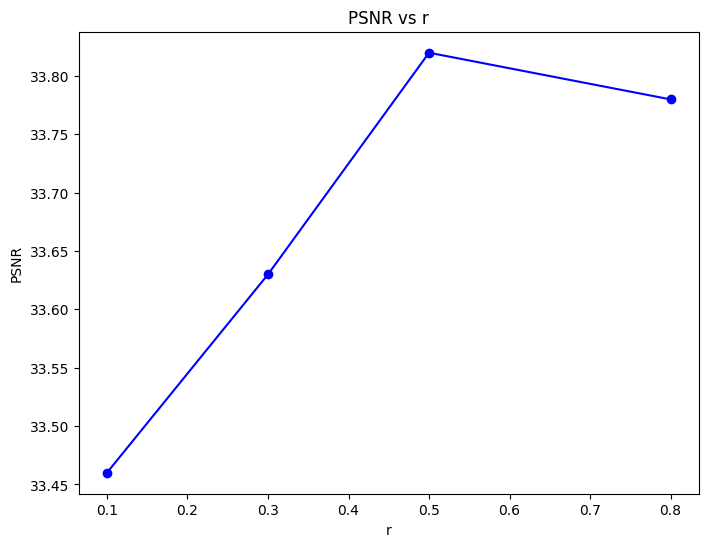

In [ ]:
# study the influence of the value of r
import matplotlib.pyplot as plt

r_values =[0.1,0.3,0.5,0.8]
psnr_values=[33.46, 33.63, 33.82, 33.78]
plt.figure(figsize=(8,6))

plt.plot(r_values,psnr_values,marker='o', linestyle='-',color='b')

plt.title('PSNR vs r')
plt.xlabel('r')
plt.ylabel('PSNR')

Conclusions: (1) Compared with the results of our method with BO (Ours-BO) and our method (Ours) with $w=[1/6, 1/6, 1/6, 1/6, 1/6, 1/6]$, the using of BO can improve the performance in PSNR about 0.5 dB.
(2) The proformance of the proposed methods have achieved the best when $r=0.5$.
(3) Our method (without BO) has achieved a better performace in PSNR than SOTA methods about 2 dB for all cases.

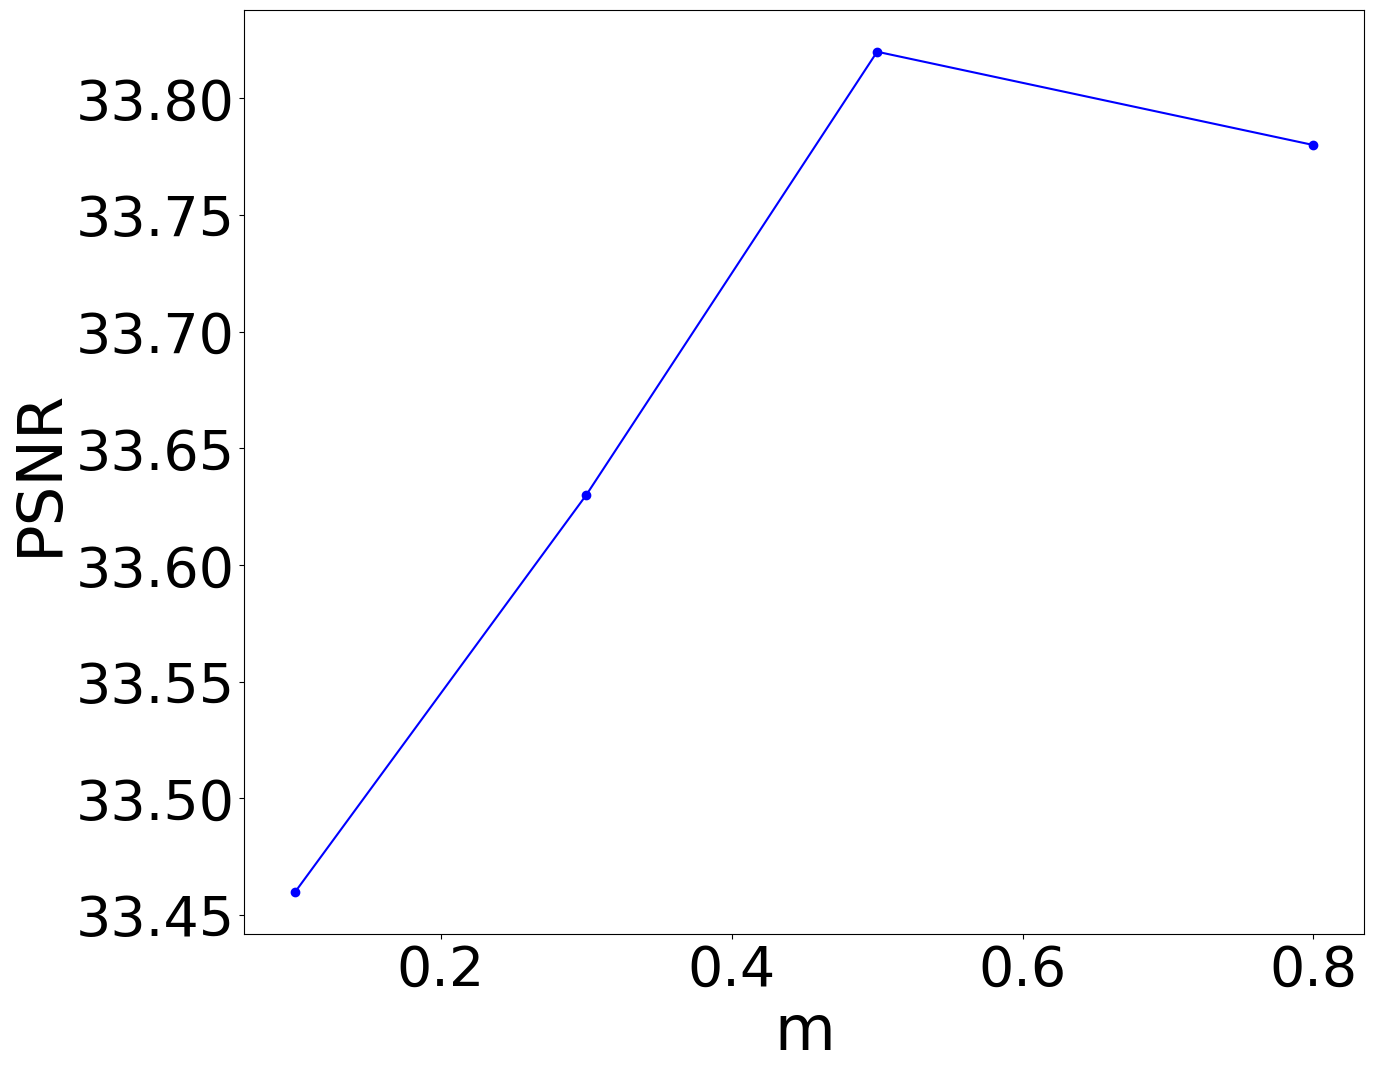

In [ ]:
import matplotlib.pyplot as plt

m_values = [0.1, 0.3, 0.5, 0.8]
psnr_values = [33.46, 33.63, 33.82, 33.78]

plt.figure(figsize=(16, 12))
plt.plot(m_values, psnr_values, marker='o', linestyle='-', color='b')
#plt.title('PSNR vs r', fontsize=25)  # 调整标题字体大小为 16
plt.xlabel('m', fontsize=45)  # 调整 x 轴标签字体大小为 14
plt.ylabel('PSNR', fontsize=45)  # 调整 y 轴标签字体大小为 14

plt.tick_params(labelsize=40)  # 调整刻度标签字体大小为 12
plt.subplots_adjust(left=0.15, right=0.85) # 调整左右边距
plt.savefig('psnr_vs_m_plot.pdf', format='pdf')

plt.show()